In [2]:
import scipy.io
import pandas as pd
import numpy as np
import imageio

mat = scipy.io.loadmat("../metadata/Metadata_Datasets/AgeDB_metadata.mat")
fileno = list(map(lambda x: x[0], mat['fileno'][0]))
filename = list(map(lambda x: x[0], mat['filename'][0]))
name = list(map(lambda x: x[0], mat['name'][0]))
age = list(map(lambda x: x[0], mat['age'][0]))
gender = list(map(lambda x: x[0], mat['gender'][0]))
metadata_agedb = pd.DataFrame(np.stack([fileno, filename, name, age, gender]).T, 
                              columns=['fileno', 'filename', 'name', 'age', 'gender'])
metadata_agedb['age'] = metadata_agedb['age'].astype(np.int)
metadata_agedb['fileno'] = metadata_agedb['fileno'].astype(np.int)
metadata_agedb['name'] = metadata_agedb['name'].astype(np.str)
metadata_agedb['filename'] = metadata_agedb['filename'].astype(np.str)

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note 

In [3]:
metadata_agedb

fileno                   filename         name  age gender
0           0     0_MariaCallas_35_f.jpg  MariaCallas   35      f
1       10000  10000_GlennClose_62_f.jpg   GlennClose   62      f
2       10001  10001_GoldieHawn_23_f.jpg   GoldieHawn   23      f
3       10002  10002_GoldieHawn_24_f.jpg   GoldieHawn   24      f
4       10003  10003_GoldieHawn_24_f.jpg   GoldieHawn   24      f
...       ...                        ...          ...  ...    ...
16483    9998   9998_GlennClose_59_f.jpg   GlennClose   59      f
16484    9999   9999_GlennClose_61_f.jpg   GlennClose   61      f
16485     999     999_CarlSagan_35_m.jpg    CarlSagan   35      m
16486      99       99_PaulAnka_46_m.jpg     PaulAnka   46      m
16487       9     9_MariaCallas_30_f.jpg  MariaCallas   30      f

[16488 rows x 5 columns]

In [3]:
import numpy as np
import pandas as pd
from keras.models import load_model, Model
import skimage
import matplotlib.pyplot as plt

In [17]:
model = load_model("../metadata/facenet_keras.h5")

In [18]:
facenet_model = Model(inputs=model.input, outputs=model.layers[-1].output)

## Which male/female identity has maximum images

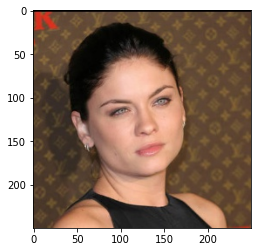

In [48]:
plt.imshow(skimage.io.imread("../metadata/CACD2000/26_Jodi_Lyn_O'Keefe_0001.jpg"))

### Hypothesis Tests to show the uncertainty of L2Norm per Age of the Subjects

## MALE ESTABLISHED IMAGES

In [5]:
# Largest Age Range
age_ranges = {}
for identity in np.unique(metadata_agedb['name']):
    age_range = np.unique(metadata_agedb.loc[metadata_agedb['name'] == identity, 'age']).astype(int).tolist()
    age_ranges[identity] = age_range

In [6]:
full_age_range = []
for identity in age_ranges.keys():
    full_age_range += age_ranges[identity]
np.unique(full_age_range)

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101])

In [7]:
from tqdm import tqdm
import random

stream_faces = None
age_bool = False
# male [1768, 1360]
np.random.seed(1000)
# established_sample = pd.concat([metadata_agedb.loc[metadata_agedb['age'] == age].sample(1) for age in np.unique(full_age_range)], axis=0)
stream_sample = metadata_agedb.copy()

In [20]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

## p-value determination

In [40]:
from tqdm import tqdm
import random
import cv2

stream_faces = None
age_bool = False
# male [1768, 1360]

stream_sample = metadata_agedb.copy()

print("Extracting the Dataset:")
res2 = []
images2 = []
for ij, str_samp in tqdm(enumerate(stream_sample.iterrows())):
    _, str_samp = str_samp
    filename2 = str_samp['filename']
    img2 = '../metadata/AgeDB' + "\\" + filename2
    image2 = cv2.resize(skimage.io.imread(img2), (160,160))
    if len(image2.shape) == 2:
        image2 = np.moveaxis(np.moveaxis(np.vstack([np.expand_dims(image2, 0)]*3), 0, 2), 0, 1)
    images2.append(image2)
    if (ij+1) % 640 == 0:
        res2.append(facenet_model(l2_normalize(prewhiten(np.vstack([img for img in images2]).reshape(-1,160,160,3)))))
        images2 = []

res2.append(facenet_model(l2_normalize(prewhiten(np.vstack([img for img in images2]).reshape(-1,160,160,3)))))

Extracting the Dataset:


16488it [12:19, 22.29it/s]


In [41]:
mean_list = []
sem_list = []
count_list = []
std_list = []

for i in range(25):
    
    newstream_sample = stream_sample.copy()
    
    import cv2
    from sklearn.metrics.pairwise import euclidean_distances
    
    established_sample = pd.concat([metadata_agedb.loc[metadata_agedb['age'] == age].sample(1) for age in np.unique(full_age_range)], axis=0)
    lambda_ = np.arange(0.1, 0.5, 0.05)

    imgs1 = []
    imgs2 = []
    images1 = []
    res1 = []
    for ii, est_samp in tqdm(enumerate(established_sample.iterrows())):
        _, est_samp = est_samp
        filename1 = est_samp['filename']
        img1 = '../metadata/AgeDB' + "\\" + filename1
        image1 = cv2.resize(imageio.imread(img1), (160,160))
        if len(image1.shape) == 2:
            image1 = np.moveaxis(np.moveaxis(np.vstack([np.expand_dims(image1, 0)]*3), 0, 2), 0, 1)
        res1.append(facenet_model(l2_normalize(prewhiten(image1.reshape(-1,160,160,3)))))
        
    norm_array = euclidean_distances(np.vstack(res2), np.vstack(res1))

    newstream_sample = stream_sample.copy()

    cols = [  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101]
    data = pd.DataFrame(norm_array.reshape(-1, len(established_sample)), columns=cols)
    
    mean = {}
    sem = {}
    count = {}
    std = {}

    for age, age_data in tqdm(data.iteritems()):
        mean[age] = age_data.loc[newstream_sample['age'] == int(age)].mean()
        std[age] = age_data.loc[newstream_sample['age'] == int(age)].std()
        count[age] = age_data.loc[newstream_sample['age'] == int(age)].count()
        sem[age] = age_data.loc[newstream_sample['age'] == int(age)].sem()
        
    nan_std = [age for age, std_value in list(std.items()) if np.isnan(std_value)]
    for age in nan_std:
        std[age] = 0
        sem[age] = 0
        
    mean_list += [mean]
    std_list += [std]
    count_list += [count]
    sem_list += [sem]

100it [00:17,  5.66it/s]
100it [00:00, 591.64it/s]
100it [00:18,  5.32it/s]
100it [00:00, 543.41it/s]
100it [00:19,  5.17it/s]
100it [00:00, 546.51it/s]
100it [00:19,  5.18it/s]
100it [00:00, 507.12it/s]
100it [00:19,  5.15it/s]
100it [00:00, 518.65it/s]
100it [00:19,  5.15it/s]
100it [00:00, 555.88it/s]
100it [00:19,  5.16it/s]
100it [00:00, 554.71it/s]
100it [00:19,  5.14it/s]
100it [00:00, 552.39it/s]
100it [00:19,  5.16it/s]
100it [00:00, 527.52it/s]
100it [00:19,  5.13it/s]
100it [00:00, 550.75it/s]
100it [00:19,  5.10it/s]
100it [00:00, 585.22it/s]
100it [00:20,  4.89it/s]
100it [00:00, 553.52it/s]
100it [00:19,  5.11it/s]
100it [00:00, 536.51it/s]
100it [00:19,  5.11it/s]
100it [00:00, 569.49it/s]
100it [00:19,  5.09it/s]
100it [00:00, 425.71it/s]
100it [00:20,  4.91it/s]
100it [00:00, 540.80it/s]
100it [00:19,  5.08it/s]
100it [00:00, 561.53it/s]
100it [00:19,  5.13it/s]
100it [00:00, 582.74it/s]
100it [00:19,  5.14it/s]
100it [00:00, 558.19it/s]
100it [00:19,  5.13it/s]
100it 

In [59]:
concat_df = []
for ii, mean_value in enumerate(mean_list):
    df = pd.DataFrame(dict(mean=list(mean_value.values()), age=list(mean_value.keys()), std=list(std_list[ii].values()), count=list(count_list[ii].values()), sem=list(sem_list[ii].values())))
    concat_df.append(df)
    
concat_df = pd.concat(concat_df, axis=1)

In [53]:
concat_df.to_csv("concept-drift-hypothesis-tests/concat_df.csv")

In [64]:
concat_df.T.to_csv("concept-drift-hypothesis-tests/concat_df.csv")

In [112]:
concat_df['age'].values[:, 0]

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101], dtype=int64)

In [97]:
new_mean = concat_df['mean'].values * concat_df['count'].values
np.round(new_mean, 2)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [56.07, 52.75, 56.07, ..., 54.74, 56.07, 48.74],
       [13.74, 13.74, 13.74, ..., 13.74, 13.74, 13.74],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [11.95, 11.95, 11.95, ..., 11.95, 11.95, 11.95],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [117]:
new_std = concat_df['std'].values * np.sqrt(concat_df['count'].values)
np.round(new_std, 2)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 8.42,  8.01,  8.42, ...,  8.68,  8.42,  8.01],
       [13.74, 13.74, 13.74, ..., 13.74, 13.74, 13.74],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [11.95, 11.95, 11.95, ..., 11.95, 11.95, 11.95],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [103]:
new_count = concat_df['count'].values
new_count

array([[1, 1, 1, ..., 1, 1, 1],
       [8, 8, 8, ..., 8, 8, 8],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [338]:
concat_df

mean  age       std  count       sem      mean  age       std  count  \
0   0.000002    1  0.000000      1  0.000000  0.000002    1  0.000000      1   
1   7.008725    3  2.976072      8  1.052200  6.593752    3  2.833681      8   
2   6.869062    4  9.714317      2  6.869060  6.869062    4  9.714317      2   
3   5.455123    5  3.742790      4  1.871395  5.455123    5  3.742790      4   
4   9.927067    6  4.158405      8  1.470218  9.927067    6  4.158405      8   
..       ...  ...       ...    ...       ...       ...  ...       ...    ...   
95  0.000003   97  0.000000      1  0.000000  0.000003   97  0.000000      1   
96  5.246943   98  7.420293      2  5.246940  5.246943   98  7.420292      2   
97  0.000004   99  0.000000      1  0.000000  0.000004   99  0.000000      1   
98  5.977260  100  8.453116      2  5.977256  5.977261  100  8.453116      2   
99  0.000003  101  0.000000      1  0.000000  0.000003  101  0.000000      1   

         sem  ...      mean  age       std  count       sem      mean  age  \
0   0.000000  ...  0.000002    1  0.000000      1  0.000000  0.000002    1   
1   1.001857  ...  7.008725    3  2.976072      8  1.052200  6.092818    3   
2   6.869060  ...  6.869062    4  9.714316      2  6.869059  6.869062    4   
3   1.871395  ...  5.455123    5  3.742790      4  1.871395  6.285200    5   
4   1.470218  ...  9.052721    6  3.711708      8  1.312287  9.927067    6   
..       ...  ...       ...  ...       ...    ...       ...       ...  ...   
95  0.000000  ...  0.000003   97  0.000000      1  0.000000  0.000003   97   
96  5.246939  ...  5.246943   98  7.420292      2  5.246939  5.246943   98   
97  0.000000  ...  0.000004   99  0.000000      1  0.000000  0.000004   99   
98  5.977256  ...  5.977260  100  8.453116      2  5.977256  5.977260  100   
99  0.000000  ...  0.000003  101  0.000000      1  0.000000  0.000003  101   

         std  count       sem  
0   0.000000      1  0.000000  
1   2.832089      8  1.001295  
2   9.714316      2  6.869059  
3   4.206071      4  2.103035  
4   4.158405      8  1.470218  
..       ...    ...       ...  
95  0.000000      1  0.000000  
96  7.420293      2  5.246940  
97  0.000000      1  0.000000  
98  8.453116      2  5.977256  
99  0.000000      1  0.000000  

[100 rows x 125 columns]

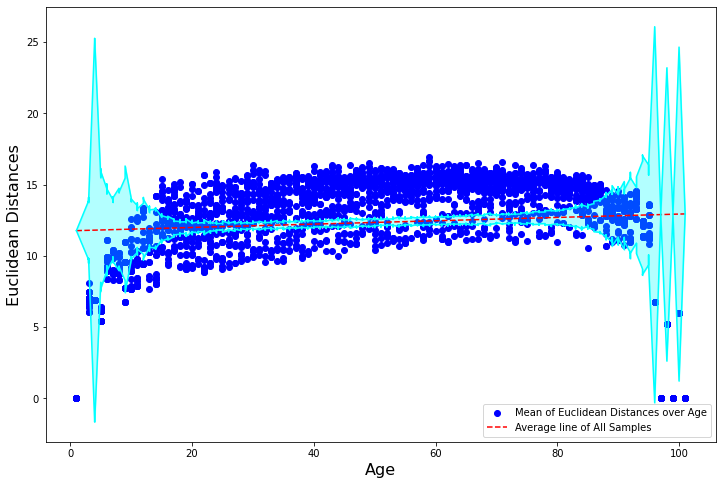

In [343]:
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(12,8))
plt.scatter(concat_df['age'].values.flatten(), concat_df['mean'].values.flatten(), color='blue', label='Mean of Euclidean Distances over Age')
plt.xlabel("Age", fontsize=16)
plt.ylabel("Euclidean Distances", fontsize=16)
lr1 = LinearRegression()
lr1.fit(concat_df['age'].values.flatten().reshape(-1,1), concat_df['mean'].values.flatten())
plt.plot(concat_df['age'].values.flatten().reshape(-1,1), 
         lr1.predict(concat_df['age'].values.flatten().reshape(-1,1)), linestyle='dashed', lw=1.5, color='red', label='Average line of All Samples')
plt.plot(concat_df['age'].values.flatten().reshape(-1,1), lr1.predict(concat_df['age'].values.reshape(-1,1)) - 1.96*concat_df['sem'].values.flatten(), color='cyan')
plt.plot(concat_df['age'].values.flatten().reshape(-1,1), lr1.predict(concat_df['age'].values.reshape(-1,1)) + 1.96*concat_df['sem'].values.flatten(), color='cyan')
plt.fill_between(concat_df['age'].values.flatten(), lr1.predict(concat_df['age'].values.flatten().reshape(-1,1)) - 1.96*concat_df['sem'].values.flatten(), lr1.predict(concat_df['age'].values.flatten().reshape(-1,1)) + 1.96*concat_df['sem'].values.flatten(), color='cyan', alpha=0.3)
plt.legend()
plt.show()

In [106]:
count_rolling = pd.DataFrame(new_count).rolling(window=25, axis=0).sum()
count_rolling

0       1       2       3       4       5       6       7       8   \
0      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
95  1426.0  1426.0  1426.0  1426.0  1426.0  1426.0  1426.0  1426.0  1426.0   
96  1272.0  1272.0  1272.0  1272.0  1272.0  1272.0  1272.0  1272.0  1272.0   
97  1135.0  1135.0  1135.0  1135.0  1135.0  1135.0  1135.0  1135.0  1135.0   
98   979.0   979.0   979.0   979.0   979.0   979.0   979.0   979.0   979.0   
99   871.0   871.0   871.0   871.0   871.0   871.0   871.0   871.0   871.0   

        9   ...      15      16      17      18      19      20      21  \
0      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..     ...  ...     ...     ...     ...     ...     ...     ...     ...   
95  1426.0  ...  1426.0  1426.0  1426.0  1426.0  1426.0  1426.0  1426.0   
96  1272.0  ...  1272.0  1272.0  1272.0  1272.0  1272.0  1272.0  1272.0   
97  1135.0  ...  1135.0  1135.0  1135.0  1135.0  1135.0  1135.0  1135.0   
98   979.0  ...   979.0   979.0   979.0   979.0   979.0   979.0   979.0   
99   871.0  ...   871.0   871.0   871.0   871.0   871.0   871.0   871.0   

        22      23      24  
0      NaN     NaN     NaN  
1      NaN     NaN     NaN  
2      NaN     NaN     NaN  
3      NaN     NaN     NaN  
4      NaN     NaN     NaN  
..     ...     ...     ...  
95  1426.0  1426.0  1426.0  
96  1272.0  1272.0  1272.0  
97  1135.0  1135.0  1135.0  
98   979.0   979.0   979.0  
99   871.0   871.0   871.0  

[100 rows x 25 columns]

In [104]:
mean_rolling = pd.DataFrame(np.round(new_mean, 2)).rolling(window=25, axis=0).mean()
mean_rolling

0         1         2         3         4         5         6   \
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
..       ...       ...       ...       ...       ...       ...       ...   
95  813.7908  799.5420  832.5972  836.0704  780.7060  829.7804  817.5512   
96  711.8260  701.3892  747.8536  741.3548  711.9992  732.4844  726.1932   
97  630.0828  632.1788  659.0696  659.6116  648.1968  649.6124  642.0768   
98  551.2656  555.3912  560.7068  566.3268  549.3472  552.3904  545.2400   
99  486.6236  493.8224  494.6600  498.6684  484.2104  487.2076  480.8816   

          7         8         9   ...        15        16        17        18  \
0        NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
2        NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
3        NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
4        NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  807.9024  814.3312  811.7088  ...  779.5824  823.9084  824.0344  823.8536   
96  740.0076  745.7596  715.4600  ...  710.0120  731.3028  735.0732  729.8436   
97  659.4952  658.5372  641.6572  ...  620.7884  646.7744  649.8828  657.0520   
98  569.8272  565.5472  547.4168  ...  551.2800  553.5420  554.2512  558.6892   
99  505.8600  499.0292  482.1456  ...  491.8176  488.9580  488.3896  493.4180   

          19        20        21        22        23        24  
0        NaN       NaN       NaN       NaN       NaN       NaN  
1        NaN       NaN       NaN       NaN       NaN       NaN  
2        NaN       NaN       NaN       NaN       NaN       NaN  
3        NaN       NaN       NaN       NaN       NaN       NaN  
4        NaN       NaN       NaN       NaN       NaN       NaN  
..       ...       ...       ...       ...       ...       ...  
95  828.6296  828.5424  830.2856  808.2808  801.3848  794.1928  
96  733.3272  735.9368  735.9472  739.5740  715.9912  702.4560  
97  651.6072  654.6696  651.7412  652.0460  646.4180  630.7264  
98  554.4260  561.3848  556.0196  558.9424  550.7864  531.9488  
99  488.1884  492.5064  494.1696  492.0944  479.3948  468.6928  

[100 rows x 25 columns]

In [120]:
std_rolling = np.sqrt(pd.DataFrame(np.round(new_std**2, 2)).rolling(window=25, axis=0).sum())
std_rolling

0           1          2          3           4          5   \
0         NaN         NaN        NaN        NaN         NaN        NaN   
1         NaN         NaN        NaN        NaN         NaN        NaN   
2         NaN         NaN        NaN        NaN         NaN        NaN   
3         NaN         NaN        NaN        NaN         NaN        NaN   
4         NaN         NaN        NaN        NaN         NaN        NaN   
..        ...         ...        ...        ...         ...        ...   
95  96.851020  101.301974  97.964330  95.986718  100.080917  95.995156   
96  93.966590   98.196996  95.076864  93.025534   94.598679  93.190128   
97  91.229436   94.637783  92.190509  90.259847   90.358342  89.365038   
98  85.856799   89.759846  89.254804  86.475950   87.445297  86.297103   
99  82.716141   85.891327  85.909196  83.471432   84.550517  83.621229   

           6          7           8          9   ...          15         16  \
0         NaN        NaN         NaN        NaN  ...         NaN        NaN   
1         NaN        NaN         NaN        NaN  ...         NaN        NaN   
2         NaN        NaN         NaN        NaN  ...         NaN        NaN   
3         NaN        NaN         NaN        NaN  ...         NaN        NaN   
4         NaN        NaN         NaN        NaN  ...         NaN        NaN   
..        ...        ...         ...        ...  ...         ...        ...   
95  95.625624  99.970896  102.335136  96.297248  ...  105.614819  96.860363   
96  92.857848  93.477484   97.342899  93.415149  ...   99.524469  93.617306   
97  89.671121  90.511436   93.991542  89.881144  ...   96.242194  90.142332   
98  86.856030  87.954875   89.933809  86.729061  ...   89.822881  87.262993   
99  83.543462  85.076671   86.565640  84.073480  ...   86.669083  84.009702   

           17         18         19         20         21         22  \
0         NaN        NaN        NaN        NaN        NaN        NaN   
1         NaN        NaN        NaN        NaN        NaN        NaN   
2         NaN        NaN        NaN        NaN        NaN        NaN   
3         NaN        NaN        NaN        NaN        NaN        NaN   
4         NaN        NaN        NaN        NaN        NaN        NaN   
..        ...        ...        ...        ...        ...        ...   
95  96.967469  97.119463  96.927653  96.253779  95.967286  97.493231   
96  94.568758  94.821517  93.615704  92.989569  92.500541  91.856682   
97  91.372096  90.293244  90.249266  90.009055  89.337898  88.799944   
98  88.171991  87.293757  87.683237  86.214152  85.768293  86.179290   
99  85.518127  84.655892  85.137536  83.058594  82.152298  82.916283   

           23         24  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  
..        ...        ...  
95  97.259036  99.732542  
96  94.189012  97.225717  
97  90.100388  93.642245  
98  86.853440  90.865945  
99  83.767715  87.383923  

[100 rows x 25 columns]

In [116]:
net_mean_rolling = mean_rolling / count_rolling
new_mean_age_rolling = net_mean_rolling.dropna(axis=0)
new_mean_age_rolling.index = concat_df['age'].values[24:, 0]
new_mean_age_rolling.style.background_gradient(cmap='coolwarm')

In [121]:
net_std_rolling = std_rolling / np.sqrt(count_rolling)
new_std_age_rolling = net_std_rolling.dropna(axis=0)
new_std_age_rolling.index = concat_df['age'].values[24:, 0]
new_std_age_rolling.style.background_gradient(cmap='coolwarm')

In [122]:
net_sem_rolling = std_rolling / count_rolling
new_sem_age_rolling = net_sem_rolling.dropna(axis=0)
new_sem_age_rolling.index = concat_df['age'].values[24:, 0]
new_sem_age_rolling.style.background_gradient(cmap='coolwarm')

In [87]:
df = pd.read_csv("concept-drift-hypothesis-tests/concat_df.csv", index_col=0)
df.style.background_gradient(cmap='coolwarm')

In [98]:
new_df = df.T
# new_df['mean'] = df.T['mean'] * df.T['count']
new_df

0     1     2     3     4     5     6     7     8     9   ...    66  \
age  count  mean   std   sem  mean   std   sem  mean   std   sem  ...   sem   
1        1     0     0     0     0     0     0     0     0     0  ...     0   
3      8.0  7.01  2.98  1.05  6.59  2.83   1.0  7.01  2.98  1.05  ...  1.08   
4      2.0  6.87  9.71  6.87  6.87  9.71  6.87  6.87  9.71  6.87  ...  6.87   
5      4.0  5.46  3.74  1.87  5.46  3.74  1.87  6.14  4.38  2.19  ...  1.87   
..     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
97       1     0     0     0     0     0     0     0     0     0  ...     0   
98     2.0  5.25  7.42  5.25  5.25  7.42  5.25  5.25  7.42  5.25  ...  5.25   
99       1     0     0     0     0     0     0     0     0     0  ...     0   
100    2.0  5.98  8.45  5.98  5.98  8.45  5.98  5.98  8.45  5.98  ...  5.98   
101      1     0     0     0     0     0     0     0     0     0  ...     0   

       67    68    69    70    71    72    73    74    75  
age  mean   std   sem  mean   std   sem  mean   std   sem  
1       0     0     0     0     0     0     0     0     0  
3    6.84  3.07  1.08  7.01  2.98  1.05  6.09  2.83   1.0  
4    6.87  9.71  6.87  6.87  9.71  6.87  6.87  9.71  6.87  
5    5.46  3.74  1.87  5.46  3.74  1.87  6.29  4.21   2.1  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
97      0     0     0     0     0     0     0     0     0  
98   5.25  7.42  5.25  5.25  7.42  5.25  5.25  7.42  5.25  
99      0     0     0     0     0     0     0     0     0  
100  5.98  8.45  5.98  5.98  8.45  5.98  5.98  8.45  5.98  
101     0     0     0     0     0     0     0     0     0  

[101 rows x 76 columns]

In [86]:
df.T

0     1     2     3     4     5     6     7     8     9   ...  \
age     count  mean   std   sem  mean   std   sem  mean   std   sem  ...   
1.00      1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3.00      8.0  7.01  2.98  1.05  6.59  2.83   1.0  7.01  2.98  1.05  ...   
4.00      2.0  6.87  9.71  6.87  6.87  9.71  6.87  6.87  9.71  6.87  ...   
5.00      4.0  5.46  3.74  1.87  5.46  3.74  1.87  6.14  4.38  2.19  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
97.00     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
98.00     2.0  5.25  7.42  5.25  5.25  7.42  5.25  5.25  7.42  5.25  ...   
99.00     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
100.00    2.0  5.98  8.45  5.98  5.98  8.45  5.98  5.98  8.45  5.98  ...   
101.00    1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

          66    67    68    69    70    71    72    73    74    75  
age      sem  mean   std   sem  mean   std   sem  mean   std   sem  
1.00     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3.00    1.08  6.84  3.07  1.08  7.01  2.98  1.05  6.09  2.83   1.0  
4.00    6.87  6.87  9.71  6.87  6.87  9.71  6.87  6.87  9.71  6.87  
5.00    1.87  5.46  3.74  1.87  5.46  3.74  1.87  6.29  4.21   2.1  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
97.00    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
98.00   5.25  5.25  7.42  5.25  5.25  7.42  5.25  5.25  7.42  5.25  
99.00    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
100.00  5.98  5.98  8.45  5.98  5.98  8.45  5.98  5.98  8.45  5.98  
101.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[101 rows x 76 columns]

In [23]:
np.arange(0,0)

array([], dtype=int32)

In [46]:
# splitting the findings into 2

p_value = np.ones((len(cols),len(cols),25))
overlap = np.zeros((len(cols),len(cols),25))
for i in tqdm(range(len(cols))):
    for j in range(len(cols)):
        mean1 = np.array([mean_list[ii][cols[i]] for ii in range(25)])
        mean2 = np.array([mean_list[ii][cols[j]] for ii in range(25)])
        mean_diff = mean1 - mean2
        std1 = np.array([std_list[ii][cols[i]] for ii in range(25)])
        std2 = np.array([std_list[ii][cols[j]] for ii in range(25)])
        sem1 = np.array([sem_list[ii][cols[i]] for ii in range(25)])
        sem2 = np.array([sem_list[ii][cols[j]] for ii in range(25)])
        count1 = np.array([count_list[ii][cols[i]] for ii in range(25)])
        count2 = np.array([count_list[ii][cols[j]] for ii in range(25)])
        # we use general two population means test
        s_pooled = np.sqrt(((count1-1)*std1**2 + (count2-1)*std2**2) / (count1 + count2 - 2))
        se_fit = s_pooled * np.sqrt(1/count1 + 1/count2)
        t_value = pd.Series(mean_diff / se_fit)
        
        # correction to detecting the difference for a single item (consider it as duplicated item)
        # replace nan with 0 such that count1 = 1 and count2 = 1 is reflected
        t_value = t_value.replace(to_replace=np.nan, value=0)
        # replace inf with 0 such that count1 = 1 and count2 = 1 is reflected
        t_value = t_value.replace(to_replace=np.inf, value=0)
        # replace inf with 0 such that count1 = 1 and count2 = 1 is reflected
        t_value = t_value.replace(to_replace=-np.inf, value=0)
        
        # 2-tailed test because mean diff may be positive or negative
        cdf_array = []
        for ii, _t_value in enumerate(t_value):
            if _t_value < 0:
                cdf1 = scipy.stats.t.cdf(_t_value, df=(count1[ii]+count2[ii]-2))*2
                if np.isnan(cdf1):
                    cdf1 = scipy.stats.t.cdf(_t_value, df=1)*2
            else:
                cdf1 = scipy.stats.t.cdf(-_t_value, df=(count1[ii] + count2[ii] - 2))*2
                if np.isnan(cdf1):
                    cdf1 = scipy.stats.t.cdf(-_t_value, df=1)*2
            cdf_array.append(cdf1)
        p_value[i,j,:] = np.array(cdf_array)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


In [47]:
prob_test_significant = p_value.flatten()[p_value.flatten() < 0.05].shape[0] / p_value.flatten().shape[0] # assumption that power of test is 0.8
power = np.zeros((len(cols),len(cols)))
alpha = np.zeros((len(cols),len(cols)))
for i in tqdm(range(len(cols))):
    for j in range(len(cols)):
        # let us assume probability(real_difference) = degree of overlap
        try:
            prob_real = p_value[i,j,:].flatten()[(p_value[i,j,:].flatten() < 0.01)].shape[0] / \
            p_value[i,j,:].flatten().shape[0]
        except Exception as e:
            prob_real = 0
        # 1 - p(real|test_sig)
        power[i,j] = prob_real * (prob_test_significant) / (prob_real * (prob_test_significant) + 0.05 * (1-prob_real))
        alpha[i,j] = (1-prob_real) * (1-prob_test_significant) / ((1-prob_real) * (1-prob_test_significant) + 0.05 * prob_real)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2021.91it/s]


array([[1.        , 0.06579654, 0.66666665, ..., 1.        , 0.66666658,
        1.        ],
       [0.06579654, 1.        , 0.91740654, ..., 0.0657966 , 0.7807723 ,
        0.06579657],
       [0.66666665, 0.91740654, 1.        , ..., 0.66666672, 0.93091132,
        0.66666669],
       ...,
       [1.        , 0.0657966 , 0.66666672, ..., 1.        , 0.66666667,
        1.        ],
       [0.66666658, 0.7807723 , 0.93091132, ..., 0.66666667, 1.        ,
        0.66666662],
       [1.        , 0.06579657, 0.66666669, ..., 1.        , 0.66666662,
        1.        ]])

In [125]:
power_df = pd.DataFrame(power).style.background_gradient(cmap='coolwarm')
power_df

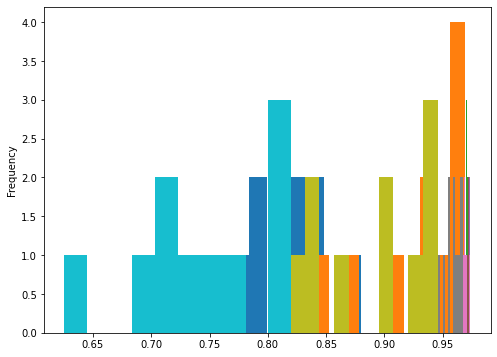

In [183]:
power_df = pd.DataFrame(power, columns=cols)
for i in range(len(power_df)//10):
    power_df.iloc[:, 10*i:10*i+10].mean(axis=0).plot.hist(figsize=(8,6))

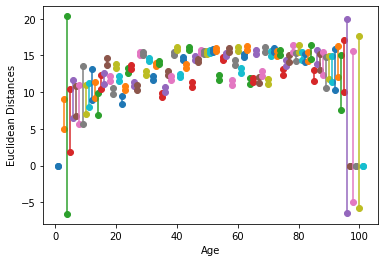

In [50]:
mean_ = mean_list[10]
std_ = std_list[10]
sem_ = sem_list[10]
count_ = count_list[10]
plt.xlabel("Age")
plt.ylabel("Euclidean Distances")
for age in np.unique(full_age_range):
    plt.plot([age]*2, [mean_[age]-1.96*sem_[age], mean_[age]+1.96*sem_[age]], marker='o', ls='-')

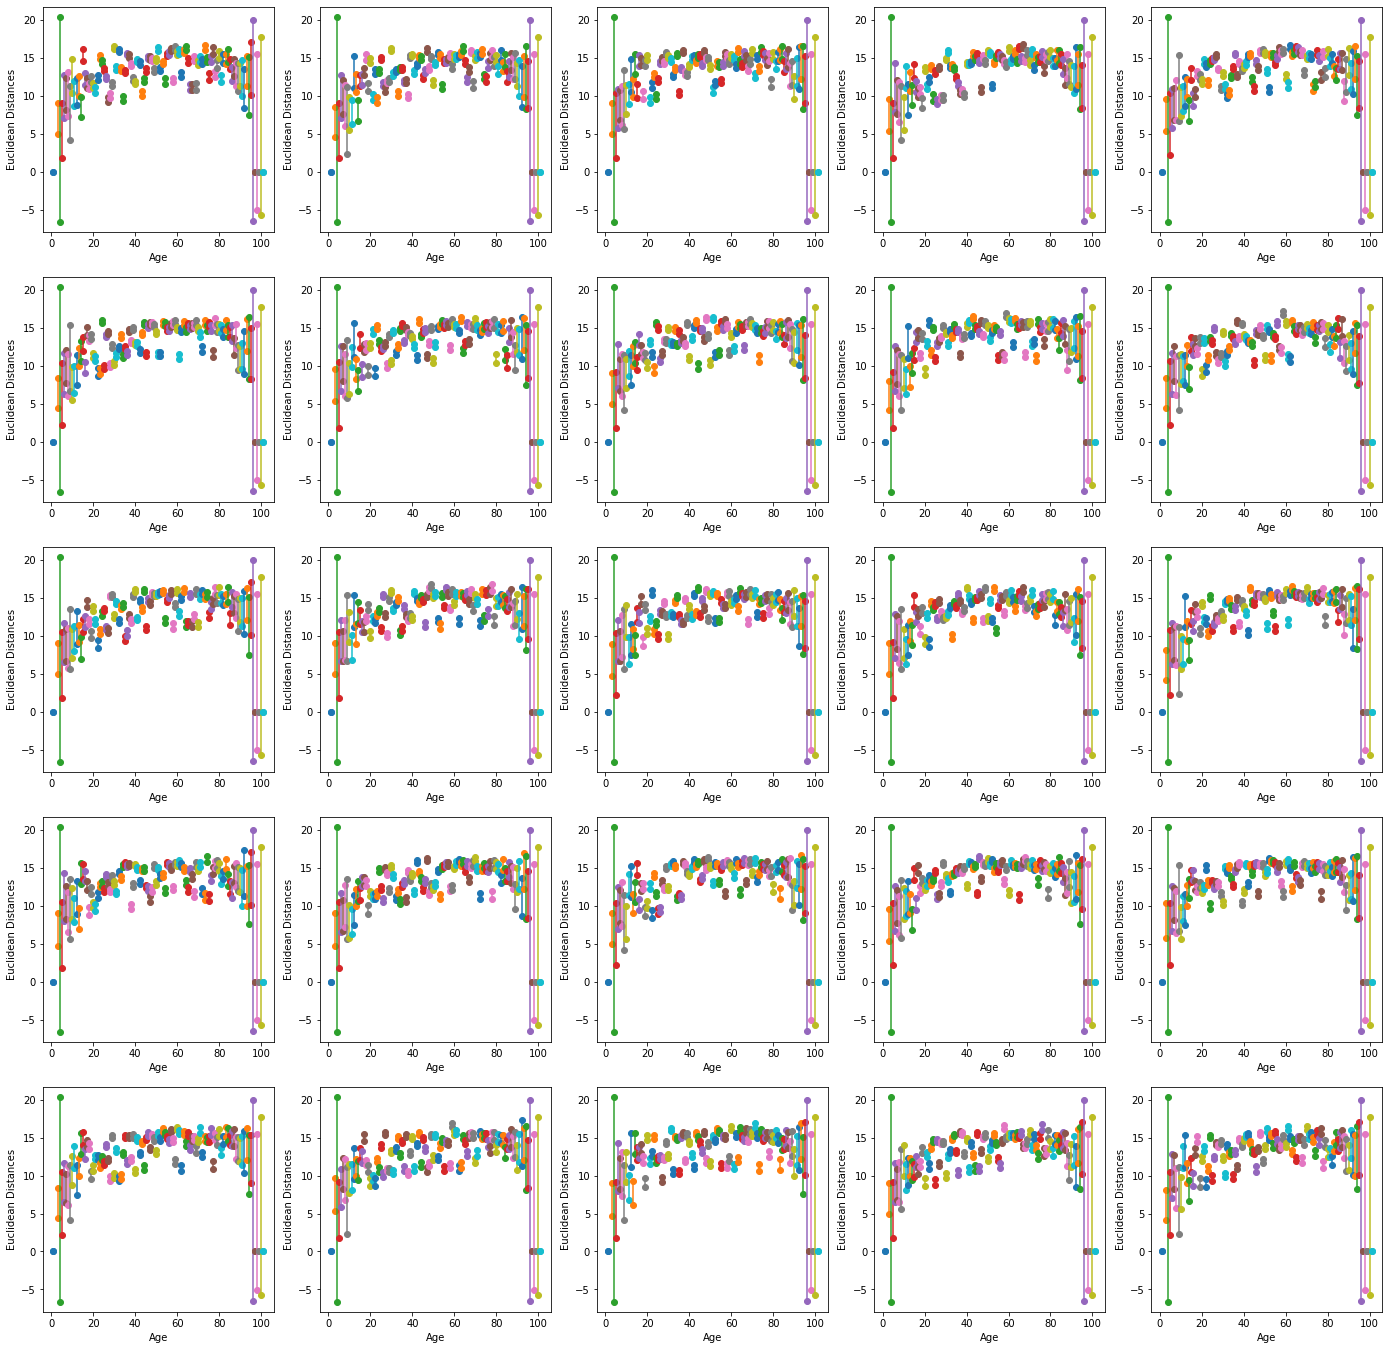

In [51]:
plt.figure(figsize=(24,24))
for ii, mean_ in enumerate(mean_list):
    std_ = std_list[ii]
    sem_ = sem_list[ii]
    count_ = count_list[ii]
    plt.subplot(5,5,ii+1)
    plt.xlabel("Age")
    plt.ylabel("Euclidean Distances")
    for age in np.unique(full_age_range):
        plt.plot([age]*2, [mean_[age]-1.96*sem_[age], mean_[age]+1.96*sem_[age]], marker='o', ls='-')

In [38]:
p = power.copy()
power_new = np.mean(p,axis=2)

In [39]:
np.unique(power_new[:,:])

array([0.        , 0.4       , 0.58181818, 0.68571429, 0.75294118,
       0.8       , 0.83478261, 0.86153846, 0.88275862, 0.9       ,
       0.91428571, 0.92631579, 0.93658537, 0.94545455, 0.95319149,
       0.96      , 0.96603774, 0.97142857, 0.97627119, 0.98064516,
       0.98461538, 0.98823529, 0.9915493 , 0.99459459, 0.9974026 ,
       1.        ])

In [63]:
data['identity'] = stream_sample['name']
data['age'] = stream_sample['age']

In [80]:
data[data['identity'] == 'GoldieHawn'].corr()

1         3         4         5         6         7         8  \
1    1.000000  0.932168  0.711783  0.937337  0.951390  0.822230  0.917304   
3    0.932168  1.000000  0.831598  0.895077  0.930551  0.865491  0.895517   
4    0.711783  0.831598  1.000000  0.748940  0.790411  0.741802  0.812457   
5    0.937337  0.895077  0.748940  1.000000  0.932988  0.792972  0.934219   
6    0.951390  0.930551  0.790411  0.932988  1.000000  0.813269  0.938401   
..        ...       ...       ...       ...       ...       ...       ...   
98   0.748682  0.662606  0.379312  0.650228  0.646991  0.721285  0.676934   
99   0.786273  0.721783  0.400275  0.656635  0.701124  0.610623  0.678660   
100  0.818105  0.758082  0.551053  0.745170  0.818402  0.525696  0.737437   
101  0.832135  0.799198  0.503611  0.732292  0.747780  0.617344  0.694038   
age  0.166123  0.037089  0.003039  0.211705  0.013756 -0.014205  0.019077   

            9        10        11  ...        93        94        95  \
1    0.960890  0.984028  0.776539  ...  0.609376  0.650289  0.739480   
3    0.887864  0.906812  0.744494  ...  0.606974  0.593112  0.735368   
4    0.695537  0.654062  0.556202  ...  0.353294  0.217482  0.464387   
5    0.936337  0.900149  0.799850  ...  0.477955  0.524559  0.606498   
6    0.953681  0.946121  0.744873  ...  0.559949  0.527913  0.642314   
..        ...       ...       ...  ...       ...       ...       ...   
98   0.677168  0.786492  0.669829  ...  0.721214  0.823966  0.741242   
99   0.703610  0.817669  0.664998  ...  0.850814  0.872471  0.874757   
100  0.820496  0.828713  0.536567  ...  0.641704  0.572975  0.684603   
101  0.740061  0.819021  0.750547  ...  0.748340  0.773062  0.866285   
age  0.125759  0.074535  0.228698  ... -0.184225  0.073727  0.114016   

           96        97        98        99       100       101       age  
1    0.627886  0.864162  0.748682  0.786273  0.818105  0.832135  0.166123  
3    0.590877  0.822837  0.662606  0.721783  0.758082  0.799198  0.037089  
4    0.378670  0.646547  0.379312  0.400275  0.551053  0.503611  0.003039  
5    0.551226  0.874289  0.650228  0.656635  0.745170  0.732292  0.211705  
6    0.556251  0.901250  0.646991  0.701124  0.818402  0.747780  0.013756  
..        ...       ...       ...       ...       ...       ...       ...  
98   0.502610  0.662005  1.000000  0.895970  0.528752  0.727114 -0.067248  
99   0.681304  0.663289  0.895970  1.000000  0.742012  0.862368 -0.059936  
100  0.827093  0.777018  0.528752  0.742012  1.000000  0.696248 -0.040891  
101  0.533183  0.597880  0.727114  0.862368  0.696248  1.000000  0.258768  
age -0.030465 -0.128612 -0.067248 -0.059936 -0.040891  0.258768  1.000000  

[101 rows x 101 columns]

## Correlation of age vs euclidean distances

In [66]:
data.to_csv("concept-drift-hypothesis-tests/data_agedb_matrix.csv")

In [67]:
table = pd.read_csv("metadata_agedb.csv")

In [70]:
files = [stream_sample.loc[t, 'filename'] for t in table.img]
files

['10007_GoldieHawn_30_f.jpg',
 '10011_GoldieHawn_37_f.jpg',
 '10018_GoldieHawn_51_f.jpg',
 '10026_GoldieHawn_65_f.jpg',
 '10036_HelenHunt_21_f.jpg',
 '10048_HelenHunt_35_f.jpg',
 '10061_HelenHunt_49_f.jpg',
 '10077_JaneBirkin_32_f.jpg',
 '10094_JaneBirkin_52_f.jpg',
 '10112_JaneFonda_30_f.jpg']

In [71]:
table['filename'] = files

In [76]:
table.sort_index().style.background_gradient(cmap='coolwarm')

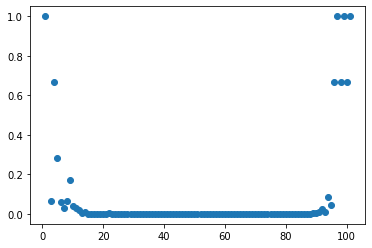

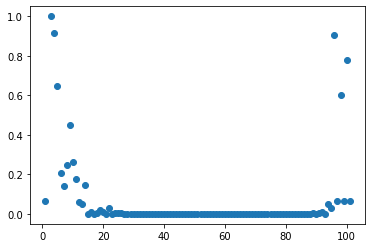

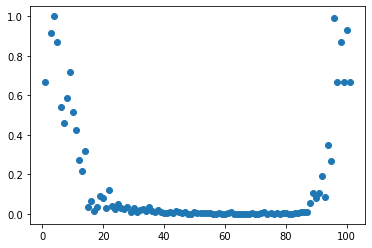

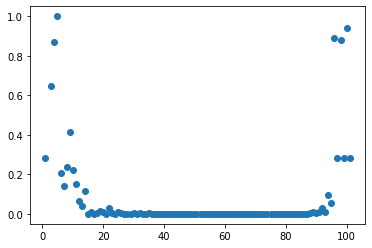

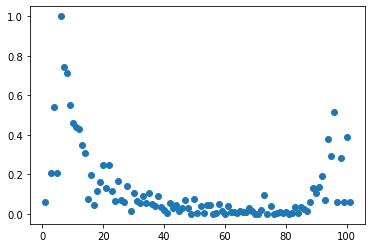

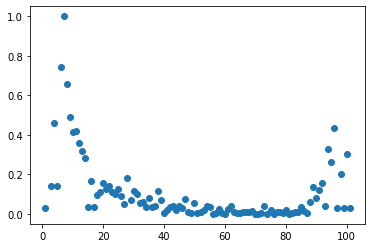

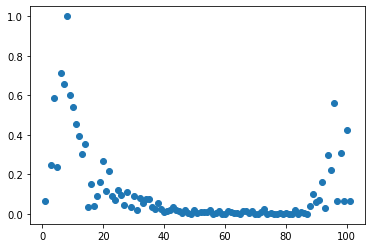

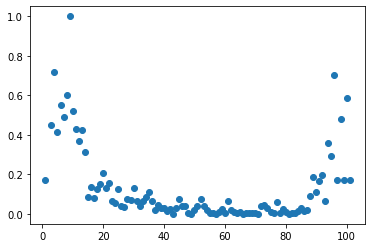

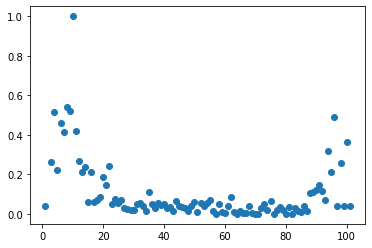

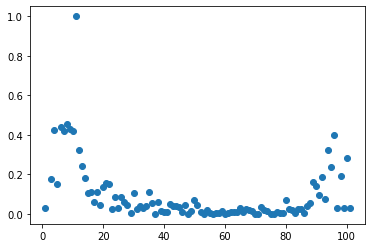

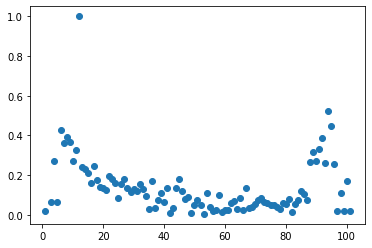

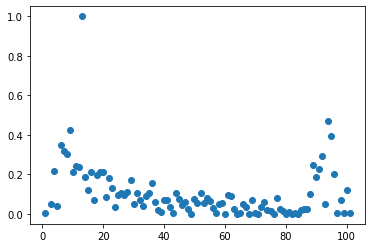

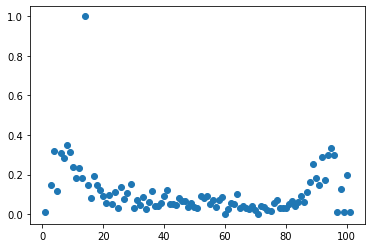

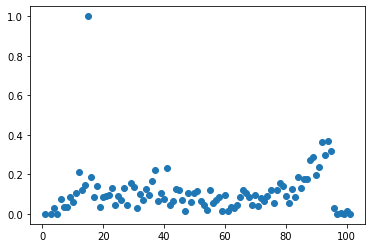

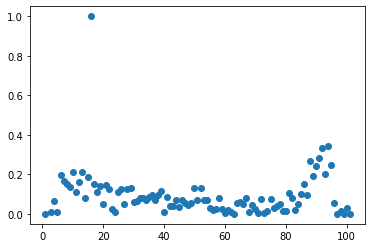

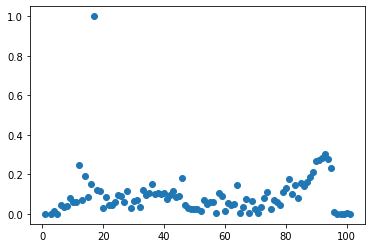

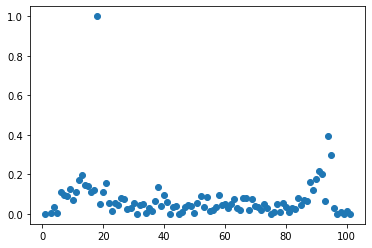

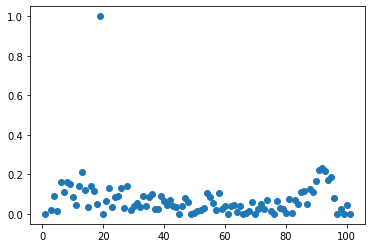

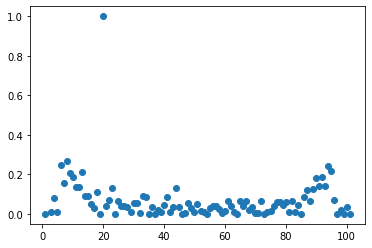

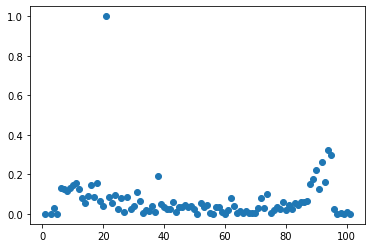

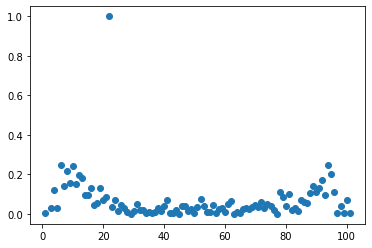

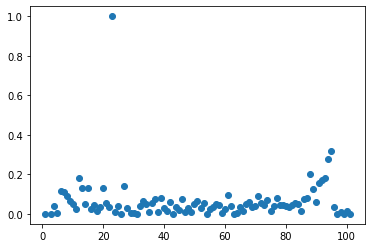

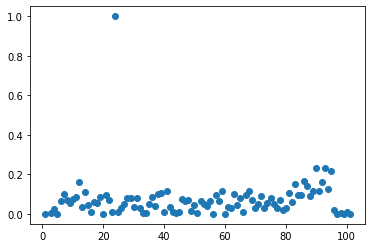

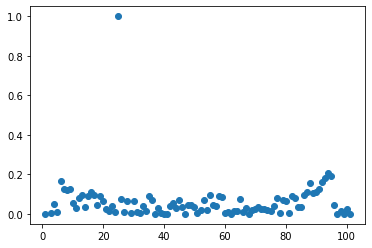

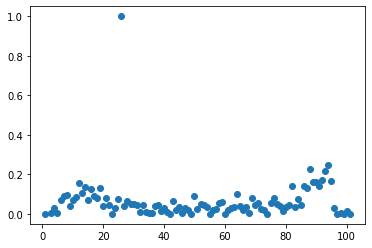

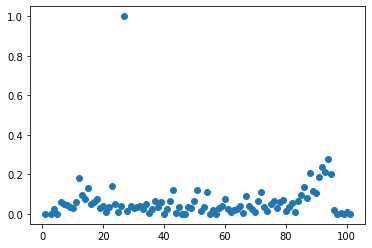

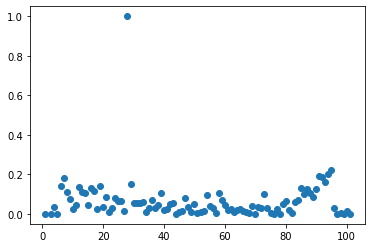

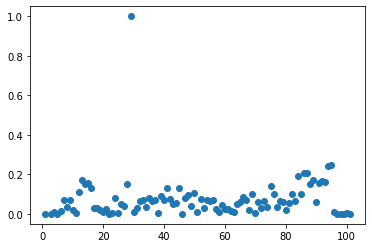

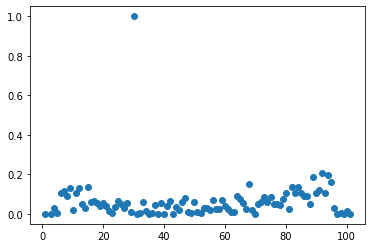

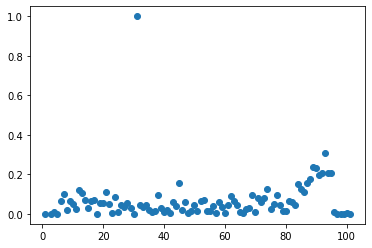

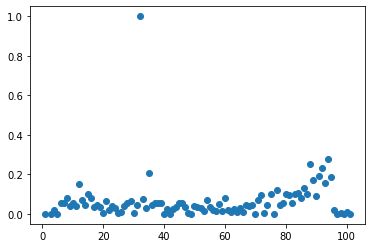

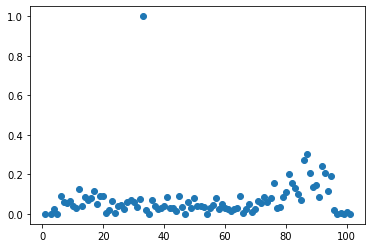

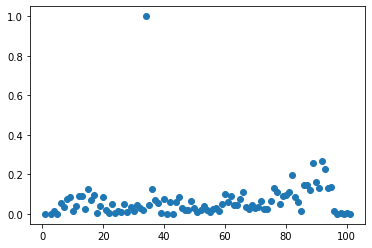

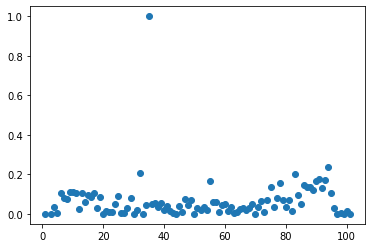

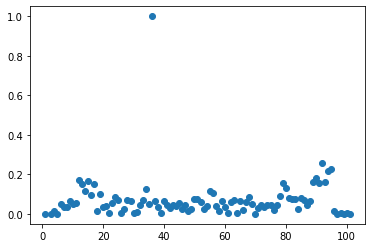

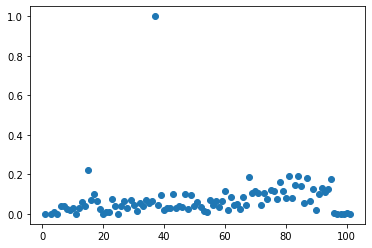

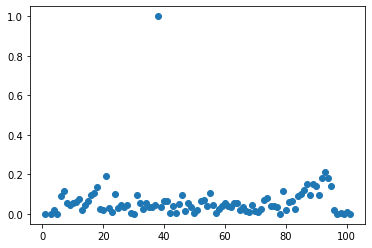

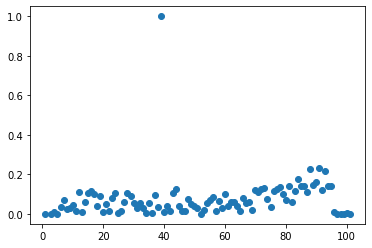

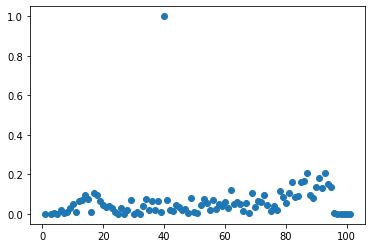

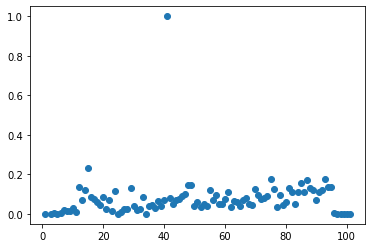

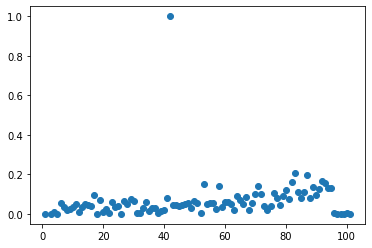

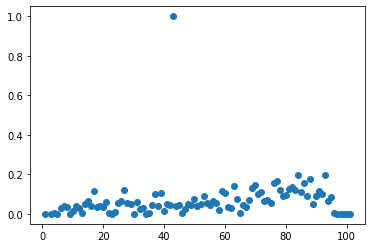

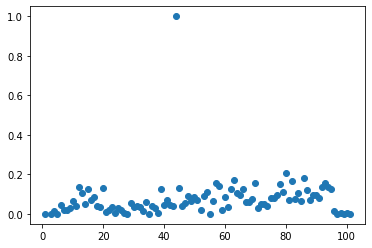

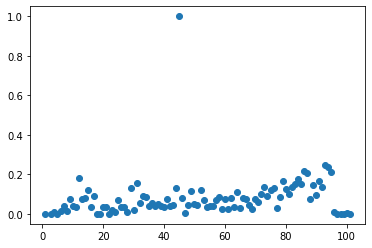

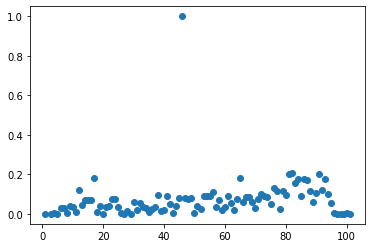

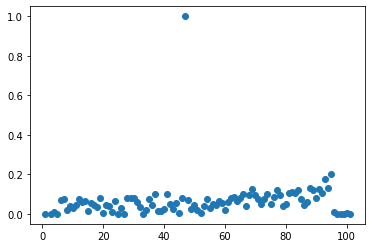

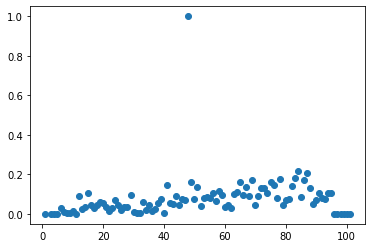

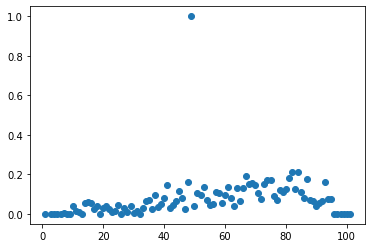

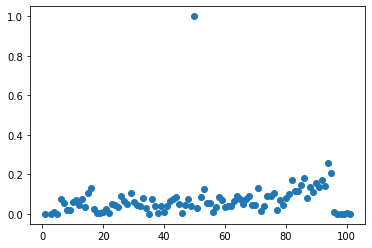

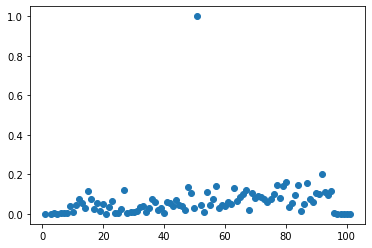

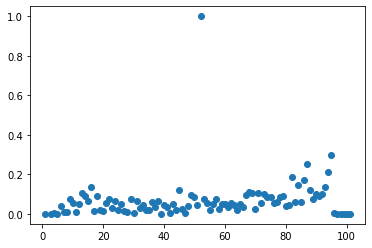

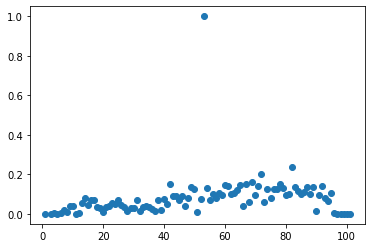

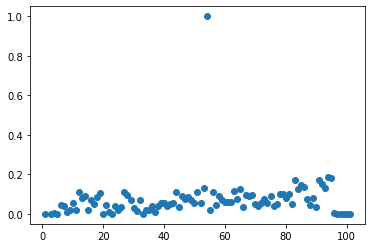

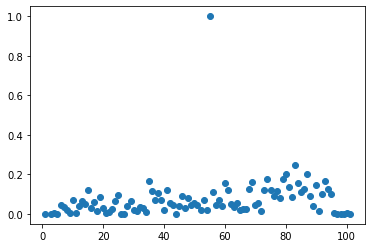

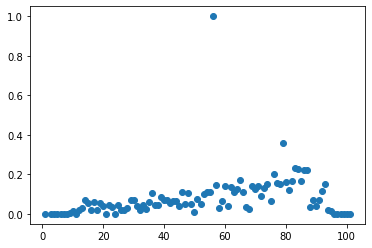

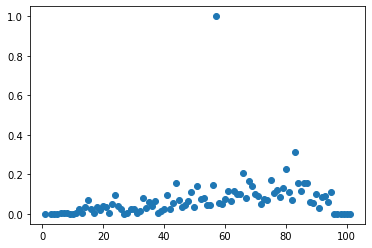

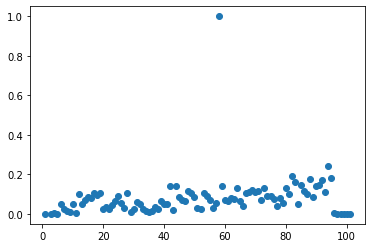

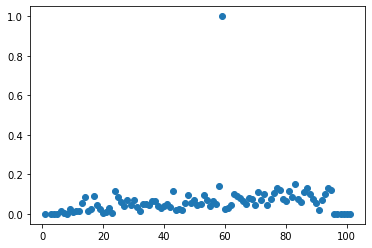

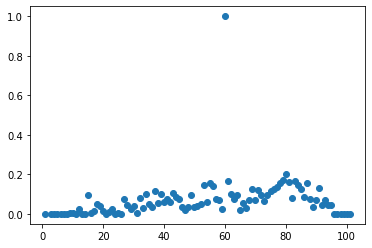

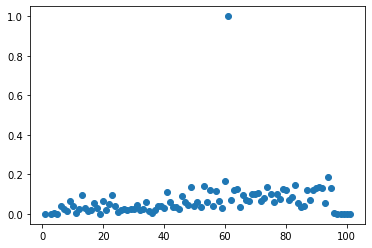

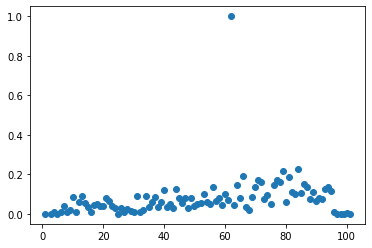

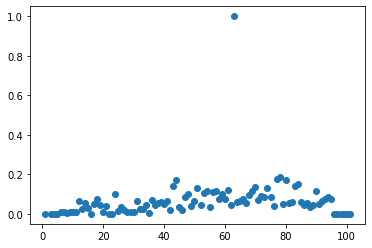

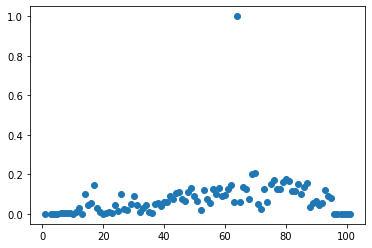

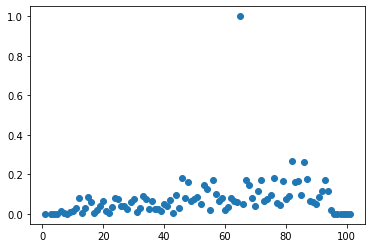

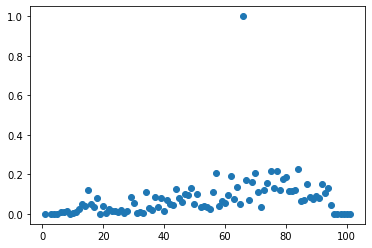

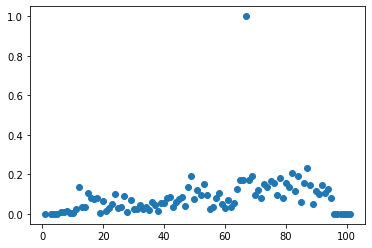

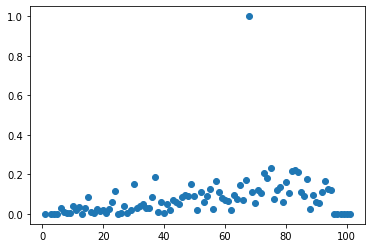

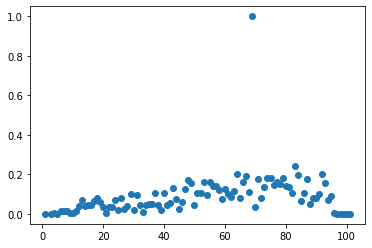

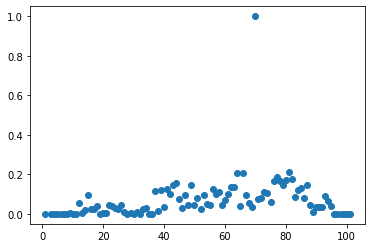

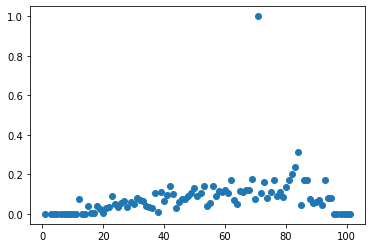

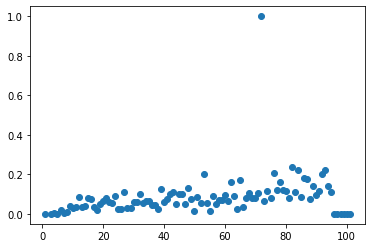

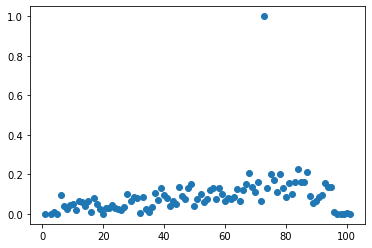

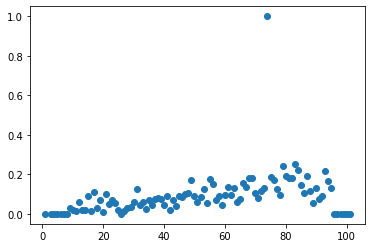

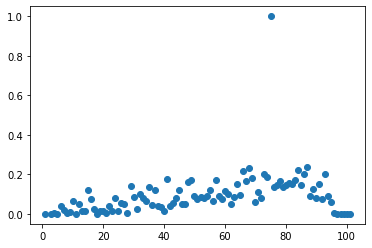

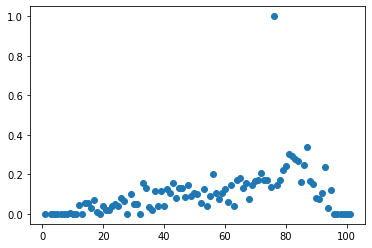

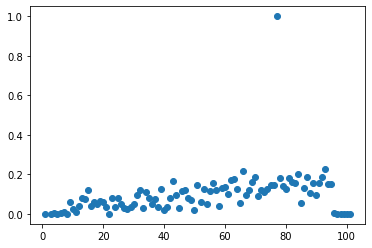

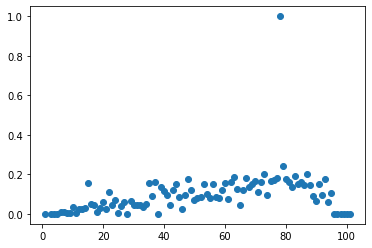

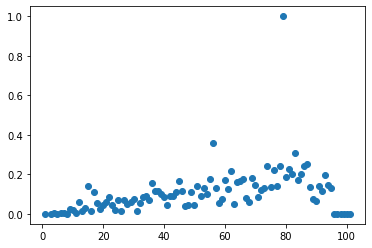

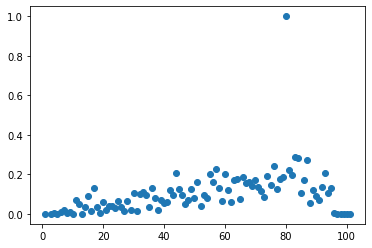

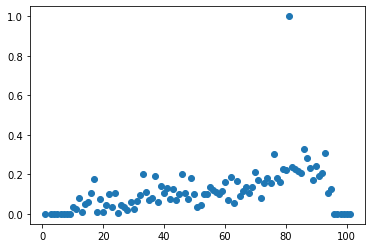

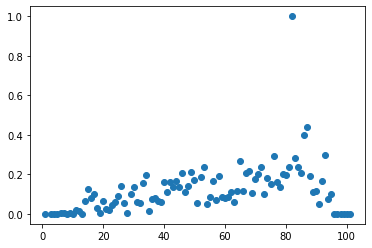

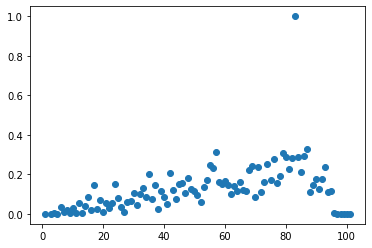

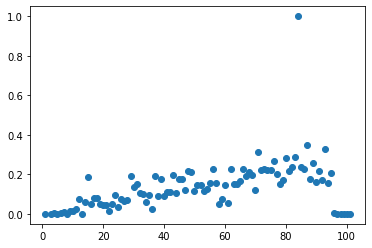

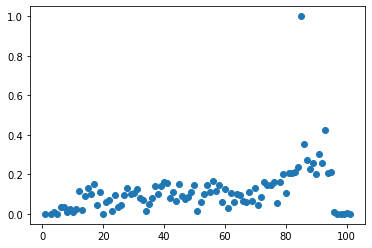

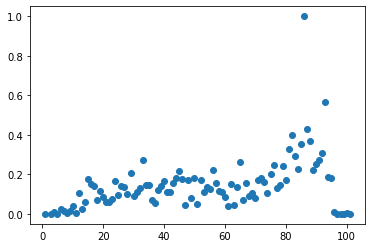

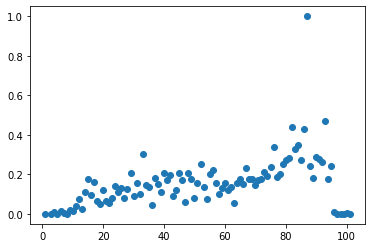

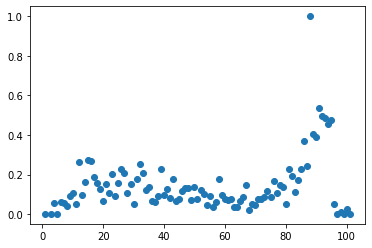

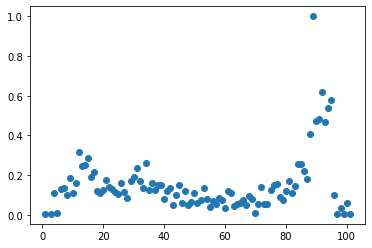

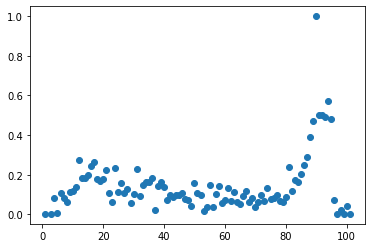

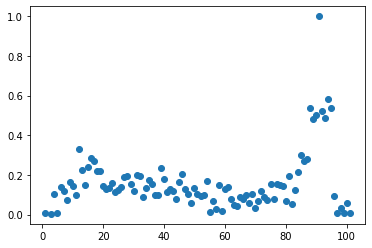

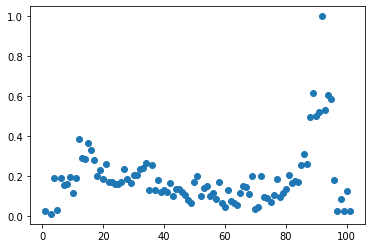

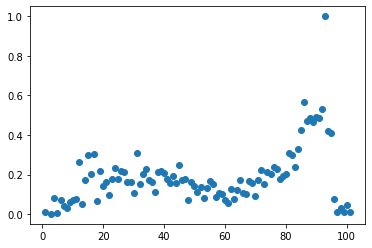

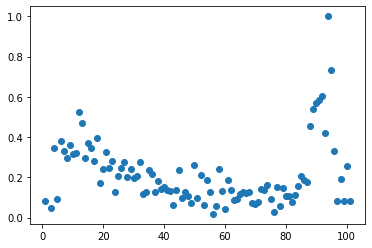

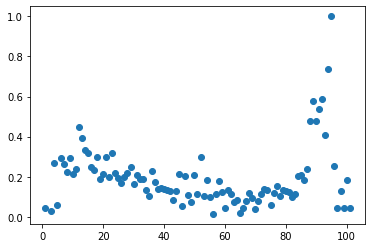

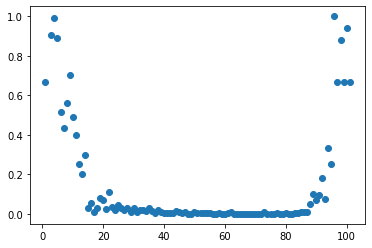

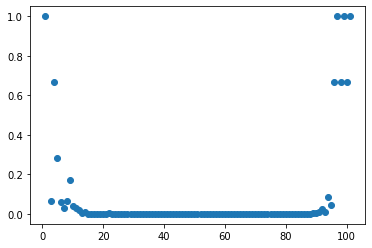

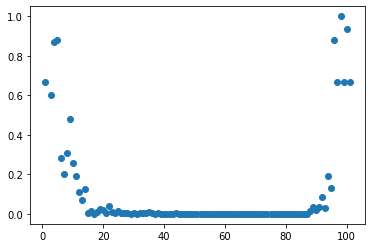

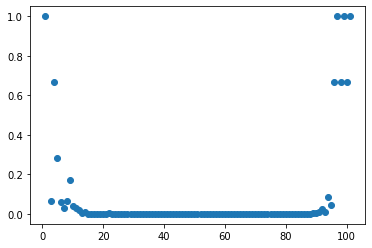

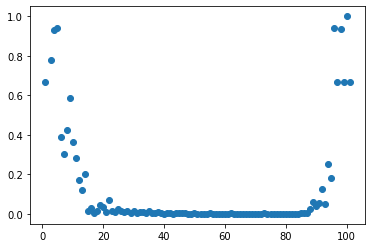

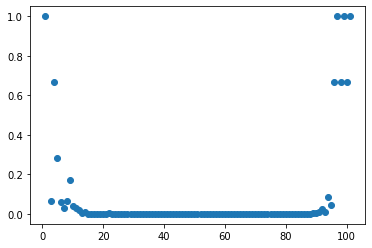

In [208]:
for i in range(100):
    plt.scatter(cols, p_value[i].mean(axis=1))
    plt.show()

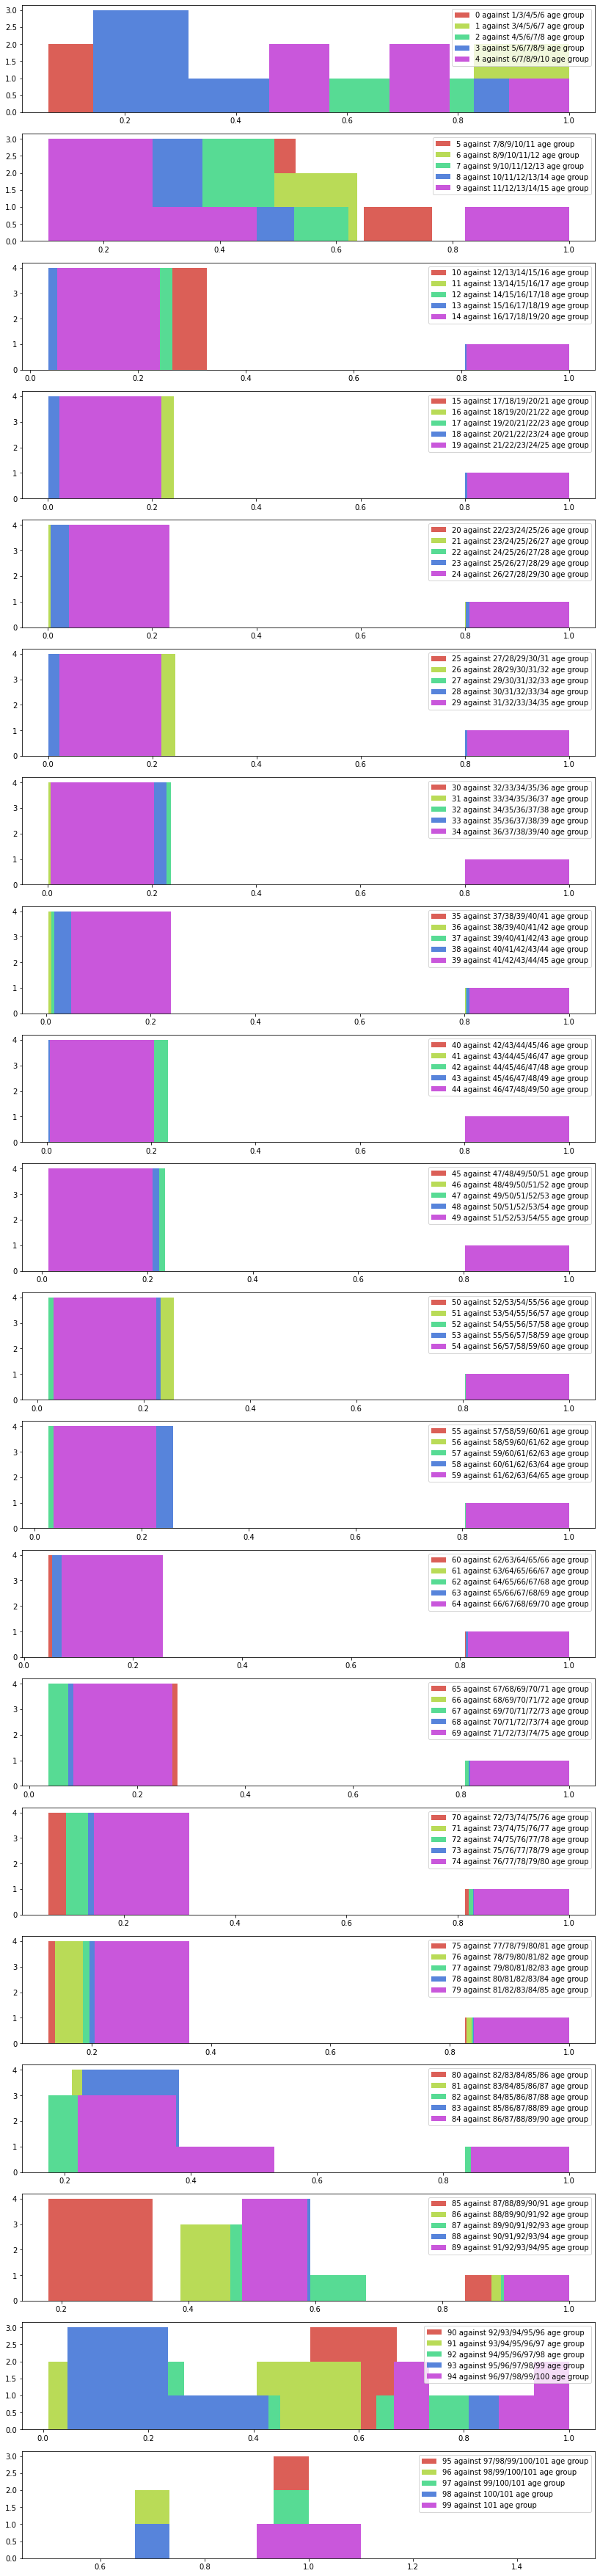

In [206]:
colors = sns.color_palette("hls", 5)
fig = plt.figure(figsize=(14,64))
for k in range(20):
    plt.subplot(20,1,k+1)
    for i in range(5):
        j = (k*5+i)
        plt.hist(p_value[j, j:j+5, :].mean(axis=1), color=colors[i], label=str(j) + " against " + "/".join(list(map(lambda x: str(x), cols[j:j+5]))) + " age group", bins=5)
        plt.legend()

<AxesSubplot:>

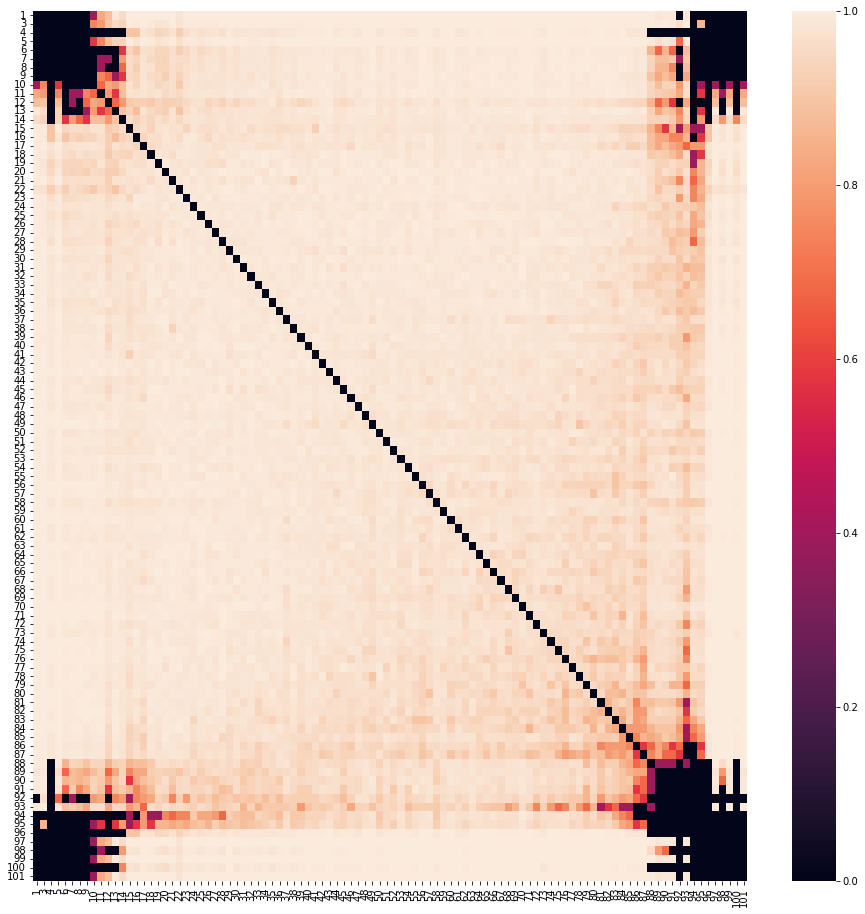

In [52]:
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(16,16))
sns.heatmap(power[:,:], xticklabels=cols, yticklabels=cols)

In [221]:
beta = 1-power

print(beta.mean(axis=0))
alpha.mean(axis=0)

[0.17532005 0.15691899 0.28061341 0.17703006 0.22333158 0.20443224
 0.22832004 0.21145669 0.16008774 0.09542593 0.18267891 0.11964541
 0.09778594 0.07447099 0.05406432 0.04380687 0.03302585 0.04057847
 0.03247877 0.02985578 0.02939127 0.02944263 0.02751372 0.03011783
 0.03093537 0.03276496 0.02920268 0.03004613 0.02984338 0.03171286
 0.03037456 0.02916844 0.02939471 0.02982153 0.02948013 0.02698732
 0.02819126 0.0285776  0.02710971 0.02879025 0.02814622 0.02808872
 0.03058677 0.02830788 0.03012857 0.03007927 0.02850695 0.029471
 0.02981584 0.02805527 0.03345663 0.02987783 0.031458   0.02812931
 0.02935376 0.03417272 0.0297009  0.02980842 0.02728718 0.02985284
 0.02962437 0.0306718  0.0303331  0.0294254  0.03519459 0.03172901
 0.03090846 0.03377393 0.03057842 0.03492611 0.03397318 0.0303636
 0.0343831  0.0373995  0.04224395 0.04172376 0.04812211 0.05379344
 0.04519077 0.05180925 0.05654945 0.06134545 0.08115791 0.05923287
 0.08480373 0.10251359 0.14639116 0.15817066 0.16107024 0.1803867

array([0.22219333, 0.27737388, 0.55122493, 0.32015047, 0.57991372,
       0.5391334 , 0.56172694, 0.54314081, 0.63417859, 0.62855497,
       0.73367223, 0.52306372, 0.63297301, 0.64477163, 0.57986087,
       0.50740766, 0.47974298, 0.45891594, 0.49051985, 0.4533647 ,
       0.4360494 , 0.47752909, 0.46141057, 0.45648206, 0.45472321,
       0.43070029, 0.48281069, 0.48259684, 0.46268621, 0.48569098,
       0.4800435 , 0.46301877, 0.46477809, 0.48043997, 0.47005947,
       0.45641164, 0.46178756, 0.48477801, 0.47144796, 0.49400678,
       0.49086472, 0.4728432 , 0.51761033, 0.49017787, 0.49692565,
       0.49454823, 0.4574809 , 0.50220037, 0.51476726, 0.48395105,
       0.52133798, 0.48394314, 0.49673314, 0.49103722, 0.50259793,
       0.49598893, 0.49500389, 0.4850326 , 0.45802315, 0.48493451,
       0.49654404, 0.49920843, 0.47863674, 0.48945318, 0.51888851,
       0.51941509, 0.490555  , 0.51183209, 0.50986858, 0.49174678,
       0.51208447, 0.51478865, 0.5033604 , 0.56536056, 0.57160

In [223]:
alpha_dict = dict(age=cols, alpha=alpha.mean(axis=0))
beta_dict = dict(age=cols, beta=beta.mean(axis=0))

In [224]:
beta_df = pd.DataFrame(beta_dict)
alpha_df = pd.DataFrame(alpha_dict)

In [225]:
beta_df

age      beta
0     1  0.175320
1     3  0.156919
2     4  0.280613
3     5  0.177030
4     6  0.223332
..  ...       ...
95   97  0.175320
96   98  0.230002
97   99  0.175320
98  100  0.265738
99  101  0.175320

[100 rows x 2 columns]

## Alpha and Beta for Age groups

In [251]:
main_df = pd.concat([alpha_df, beta_df], axis=1).loc[:, ['age', 'alpha', 'beta']]
new_main_df = main_df.T
a_new_main_df = pd.DataFrame(new_main_df.loc[['alpha', 'beta'], :], columns=main_df['age'].values[:, 0])
a_new_main_df.style.background_gradient(cmap='coolwarm')

In [249]:
a_new_main_df

1         3         4        5         6         7         8    \
age    1.000000  3.000000  4.000000  5.00000  6.000000  7.000000  8.000000   
age    1.000000  3.000000  4.000000  5.00000  6.000000  7.000000  8.000000   
alpha  0.222193  0.277374  0.551225  0.32015  0.579914  0.539133  0.561727   
beta   0.175320  0.156919  0.280613  0.17703  0.223332  0.204432  0.228320   

            9          10         11   ...        92         93         94   \
age    9.000000  10.000000  11.000000  ...  92.000000  93.000000  94.000000   
age    9.000000  10.000000  11.000000  ...  92.000000  93.000000  94.000000   
alpha  0.543141   0.634179   0.628555  ...   0.852335   0.840320   0.862432   
beta   0.211457   0.160088   0.095426  ...   0.285700   0.233756   0.397087   

             95         96         97         98         99          100  \
age    95.000000  96.000000  97.000000  98.000000  99.000000  100.000000   
age    95.000000  96.000000  97.000000  98.000000  99.000000  100.000000   
alpha   0.843261   0.535793   0.222193   0.388202   0.222193    0.466535   
beta    0.300174   0.279472   0.175320   0.230002   0.175320    0.265738   

              101  
age    101.000000  
age    101.000000  
alpha    0.222193  
beta     0.175320  

[4 rows x 100 columns]

## Image Correlation

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from 'C:\\Users\\burse\\AppData\\Roaming\\Python\\Python37\\site-packages\\pandas\\core\\internals\\blocks.py'>

In [13]:
ef.shape

(15921, 128)

In [1]:
def correlation(img1, img2, calc='row'):
    
    corr = None
    
    def corr_by_channel(img1, img2, channel=None):
        corr = np.zeros(img1.shape[0])
        for i in range(img1.shape[0 if calc == 'row' else 1]):
            i1 = img1[i, channel].flatten() if calc == 'row' else img1[:, i, channel].flatten()
            i2 = img2[i, channel].flatten() if calc == 'row' else img2[:, i, channel].flatten()

            covariance = np.cov(i1, i2)
            sxy = covariance[0,1]
            sx = np.std(i1)
            sy = np.std(i2)

            corr[i] = sxy/(sx*sy)
        
        return corr
    
    if (len(img1.shape) == 2 or len(img1.shape) == 3) and (len(img2.shape) == 2 or len(img2.shape) == 3):
        if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
            raise Exception("images shapes are not equal")
        if len(img1.shape) == 2:
            corr = corr_by_channel(img1, img2)
        elif len(img1.shape) == 3:
            corr = np.stack([corr_by_channel(img1[:,:,i], img2[:,:,i], i)]).T
            
    return corr

In [7]:
correlation(imageio.imread("facenet_with_aging/hash_sample_1.0/offset_0_aging_0_age_2325_AbeVigoda_49_m.jpg.png"), 
           imageio.imread("facenet_with_aging/hash_sample_1.0/offset_1_aging_0_age_2325_AbeVigoda_49_m.jpg.png"), 
            calc='row').shape

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


(49,)

In [215]:
img = imageio.imread("facenet_with_aging/hash_sample_1.0/offset_2_aging_0.png")
np.cov(img)

array([[ 8782.7372449 ,  8319.68664966,  7086.88307823, ...,
        -2191.16411565, -1795.14668367, -1926.73639456],
       [ 8319.68664966,  8446.09438776,  7060.89498299, ...,
        -1909.88732993, -1466.69727891, -1762.46853741],
       [ 7086.88307823,  7060.89498299,  7148.1122449 , ...,
        -1604.80994898, -1201.54251701, -1298.25722789],
       ...,
       [-2191.16411565, -1909.88732993, -1604.80994898, ...,
         2954.93282313,  2514.4460034 ,  2162.98894558],
       [-1795.14668367, -1466.69727891, -1201.54251701, ...,
         2514.4460034 ,  2899.84438776,  2349.92729592],
       [-1926.73639456, -1762.46853741, -1298.25722789, ...,
         2162.98894558,  2349.92729592,  2541.78826531]])

In [221]:
corr = np.cov(img) / np.std(img.flatten())**2

In [228]:
orig_img = cv2.resize(cv2.cvtColor(imageio.imread("concept-drift-hypothesis-tests/5368_JohnMalkovich_34_m.jpg"), cv2.COLOR_RGB2GRAY), (49,49))
img = imageio.imread("facenet_with_aging/hash_sample_1.0/offset_1_aging_0.png")

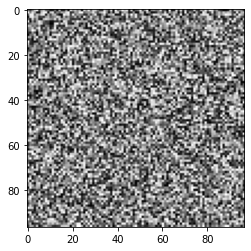

In [231]:
import scipy.signal

plt.imshow(scipy.signal.correlate2d(orig_img, img), cmap='gray')

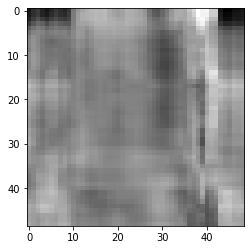

In [238]:
plt.imshow((orig_img - orig_img.mean()).dot(img - img.mean()) / (49*49) / np.std(orig_img) / np.std(img), cmap='gray')

In [239]:
import skimage.metrics

skimage.metrics.peak_signal_noise_ratio(orig_img, img)

27.420545479356765

In [5]:
from glob import glob

images_iter = glob('facenet_with_aging/*/*.png')

In [6]:
images_iter[0]

'facenet_with_aging\\hash_sample_1.0\\offset_0_aging_0_age_2325_AbeVigoda_49_m.jpg.png'

In [175]:
import cv2
from skimage.util import img_as_ubyte
filenames = []
ages = []
psnrs = []
psnrs_pca = []
psnrs_original = []
for image in tqdm(images_iter):
    idx = image.index("age_")
    filename = image[idx:].replace(".jpg.png", "")
    filename = filename[filename.find("age_")+4:]
    filenames.append(filename)
    age = int(filename.split("_")[2])
    ages.append(age)
    
    image_item = imageio.imread(image)
    
    orig_img = imageio.imread("../metadata/AgeDB/" + filename + ".jpg")
    if len(orig_img.shape) == 3:
        orig_img = cv2.cvtColor(cv2.resize(orig_img, (49,49)), cv2.COLOR_RGB2GRAY)
    else:
        orig_img = cv2.resize(orig_img, (49,49))
    
    noise_img = random_noise(image_item, mode='s&p',amount=0.2)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    
    noise_orig_img = random_noise(image_item, mode='s&p',amount=0.2)
    noise_orig_img = np.array(255*noise_orig_img, dtype = 'uint8')
    
    denoised = cv2.fastNlMeansDenoising(noise_img,2,5,7, cv2.NORM_L2)
    denoised_orig = cv2.fastNlMeansDenoising(noise_orig_img,2,5,7, cv2.NORM_L2)
    
    psnrs.append(skimage.metrics.peak_signal_noise_ratio(image_item, denoised))
    psnrs_original.append(skimage.metrics.peak_signal_noise_ratio(orig_img, denoised_orig))
    psnrs_pca.append(skimage.metrics.peak_signal_noise_ratio(orig_img, image_item))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3156/3156 [02:10<00:00, 24.21it/s]


In [192]:
import cv2
from skimage.util import img_as_ubyte
filenames = []
ages = []
psnrs = []
psnrs_pca = []
psnrs_original = []
for image in tqdm(images_iter[2:5]):
    idx = image.index("age_")
    filename = image[idx:].replace(".jpg.png", "")
    filename = filename[filename.find("age_")+4:]
    filenames.append(filename)
    age = int(filename.split("_")[2])
    ages.append(age)
    
    image_item = imageio.imread(image)
    
    orig_img = imageio.imread("../metadata/AgeDB/" + filename + ".jpg")
    if len(orig_img.shape) == 3:
        orig_img = cv2.cvtColor(cv2.resize(orig_img, (49,49)), cv2.COLOR_RGB2GRAY)
    else:
        orig_img = cv2.resize(orig_img, (49,49))
    
    noise_img = random_noise(image_item, mode='s&p',amount=0.2)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    
    noise_orig_img = random_noise(image_item, mode='s&p',amount=0.2)
    noise_orig_img = np.array(255*noise_orig_img, dtype = 'uint8')
    
    denoised = cv2.fastNlMeansDenoising(noise_img,2,5,7, cv2.NORM_L2)
    denoised_orig = cv2.fastNlMeansDenoising(noise_orig_img,2,5,7, cv2.NORM_L2)
    
    residual_orig = orig_img - denoised_orig
    residual_img = image_item - denoised
    
    imageio.imwrite(filename + ".jpg", orig_img)
    imageio.imwrite(filename + "_pca.jpg", image_item)
    imageio.imwrite(filename + "_denoised_orig.jpg", denoised_orig)
    imageio.imwrite(filename + "_denoised.jpg", denoised)
    imageio.imwrite(filename + "_residual_orig.jpg", residual_orig)
    imageio.imwrite(filename + "_residual_img.jpg", residual_img)
    
    psnrs.append(skimage.metrics.peak_signal_noise_ratio(image_item, denoised))
    psnrs_original.append(skimage.metrics.peak_signal_noise_ratio(orig_img, denoised_orig))
    psnrs_pca.append(skimage.metrics.peak_signal_noise_ratio(orig_img, image_item))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.57it/s]


In [176]:
quality_df = pd.DataFrame(dict(ages=ages, psnrs=psnrs, filenames=filenames, psnrs_original=psnrs_original, 
                              psnrs_pca=psnrs_pca))
quality_df

ages      psnrs                  filenames  psnrs_original  psnrs_pca
0       49  11.862751        2325_AbeVigoda_49_m       11.935495  21.994133
1       49  11.866413        2325_AbeVigoda_49_m       11.822327  21.994133
2       25  11.097590      3885_TomasMilian_25_m       10.942443  22.070941
3       25  11.150553      3885_TomasMilian_25_m       10.800808  22.070941
4       40  10.786878       6034_RafVallone_40_m       11.048096  30.009803
...    ...        ...                        ...             ...        ...
3151    29  11.817014  15673_KathrynGrayson_29_f       11.697179  32.738088
3152     7  11.016342   12781_MargaretOBrien_7_f       11.458710  34.627145
3153     7  12.080044   12781_MargaretOBrien_7_f       11.960175  34.627145
3154    54  11.312964       9933_AliMacGraw_54_f       11.610358  20.647431
3155    54  11.557506       9933_AliMacGraw_54_f       11.418211  20.647431

[3156 rows x 5 columns]

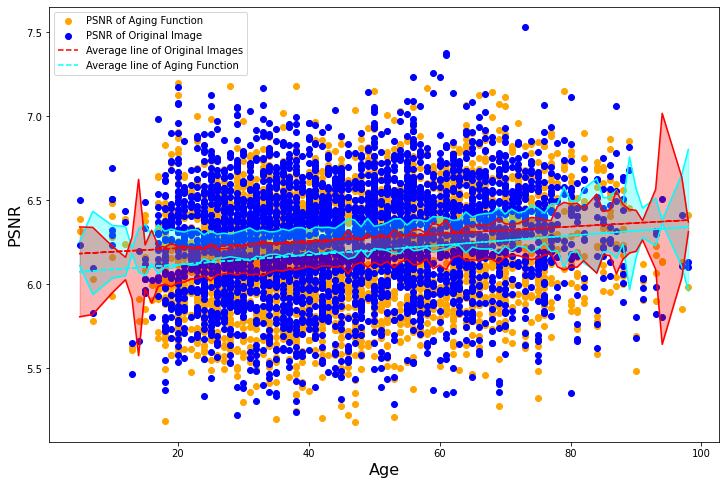

In [337]:
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(12,8))
plt.scatter(quality_df['ages'], quality_df['psnrs'], color='orange', label='PSNR of Aging Function')
plt.scatter(quality_df['ages'], quality_df['psnrs_original'], color='blue', label='PSNR of Original Image')
plt.xlabel("Age", fontsize=16)
plt.ylabel("PSNR", fontsize=16)
lr1 = LinearRegression()
lr1.fit(quality_df['ages'].values.reshape(-1,1), quality_df['psnrs_original'])
lr2 = LinearRegression()
lr2.fit(quality_df['ages'].values.reshape(-1,1), quality_df['psnrs'])
plt.plot(quality_df['ages'], lr1.predict(quality_df['ages'].values.reshape(-1,1)), linestyle='dashed', lw=1.5, color='red', label='Average line of Original Images')
plt.plot(quality_df['ages'], lr2.predict(quality_df['ages'].values.reshape(-1,1)), linestyle='dashed', lw=1.5, color='cyan', label='Average line of Aging Function')
sem = quality_df.groupby('ages')[['psnrs', 'psnrs_original']].sem()
plt.plot(sem.index, lr1.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs, color='cyan')
plt.plot(sem.index, lr1.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs, color='cyan')
plt.plot(sem.index, lr2.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs_original, color='red')
plt.plot(sem.index, lr2.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs_original, color='red')
plt.fill_between(sem.index, lr1.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs, lr1.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs, color='cyan', alpha=0.3)
plt.fill_between(sem.index, lr2.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs_original, lr2.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs_original, color='red', alpha=0.3)
plt.legend()
plt.show()

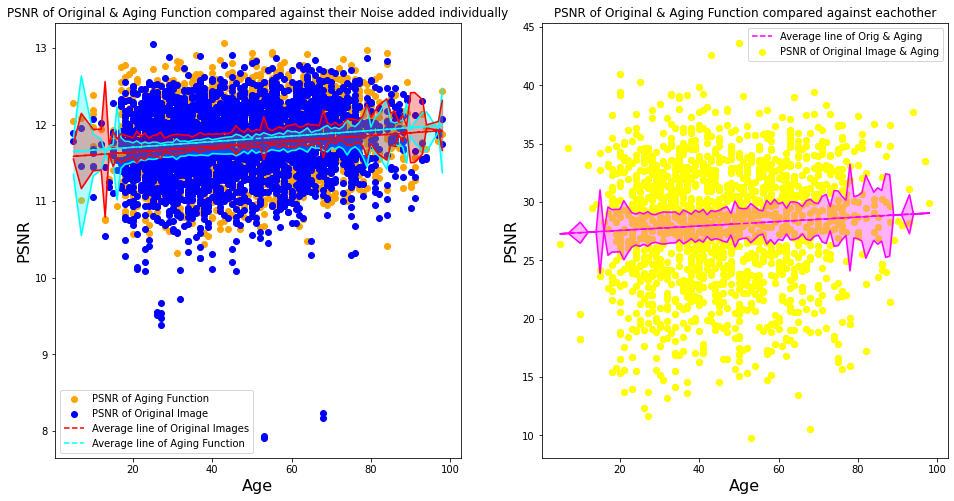

In [189]:
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(quality_df['ages'], quality_df['psnrs'], color='orange', label='PSNR of Aging Function')
plt.scatter(quality_df['ages'], quality_df['psnrs_original'], color='blue', label='PSNR of Original Image')
plt.title("PSNR of Original & Aging Function compared against their Noise added individually")
plt.xlabel("Age", fontsize=16)
plt.ylabel("PSNR", fontsize=16)
lr1 = LinearRegression()
lr1.fit(quality_df['ages'].values.reshape(-1,1), quality_df['psnrs_original'])
lr2 = LinearRegression()
lr2.fit(quality_df['ages'].values.reshape(-1,1), quality_df['psnrs'])
lr3 = LinearRegression()
lr3.fit(quality_df['ages'].values.reshape(-1,1), quality_df['psnrs_pca'])
plt.plot(quality_df['ages'], lr1.predict(quality_df['ages'].values.reshape(-1,1)), linestyle='dashed', lw=1.5, color='red', label='Average line of Original Images')
plt.plot(quality_df['ages'], lr2.predict(quality_df['ages'].values.reshape(-1,1)), linestyle='dashed', lw=1.5, color='cyan', label='Average line of Aging Function')
sem = quality_df.groupby('ages')[['psnrs', 'psnrs_original', 'psnrs_pca']].sem()
plt.plot(sem.index, lr1.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs, color='cyan')
plt.plot(sem.index, lr1.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs, color='cyan')
plt.plot(sem.index, lr2.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs_original, color='red')
plt.plot(sem.index, lr2.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs_original, color='red')
plt.fill_between(sem.index, lr1.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs, lr1.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs, color='cyan', alpha=0.3)
plt.fill_between(sem.index, lr2.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs_original, lr2.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs_original, color='red', alpha=0.3)
plt.legend()
plt.subplot(1,2,2)
plt.xlabel("Age", fontsize=16)
plt.ylabel("PSNR", fontsize=16)
plt.plot(quality_df['ages'], lr3.predict(quality_df['ages'].values.reshape(-1,1)), linestyle='dashed', lw=1.5, color='magenta', label='Average line of Orig & Aging')
plt.scatter(quality_df['ages'], quality_df['psnrs_pca'], color='yellow', label='PSNR of Original Image & Aging')
plt.plot(sem.index, lr3.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs_pca, color='magenta')
plt.plot(sem.index, lr3.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs_pca, color='magenta')
plt.fill_between(sem.index, lr3.predict(sem.index.values.reshape(-1,1)) - 1.96*sem.psnrs_pca, lr3.predict(sem.index.values.reshape(-1,1)) + 1.96*sem.psnrs_pca, color='magenta', alpha=0.3)
plt.title("PSNR of Original & Aging Function compared against eachother")
plt.legend()
plt.show()

In [186]:
quality_df.groupby('ages')[['psnrs', 'psnrs_original', 'psnrs_pca']].sem().replace(np.nan, 0).style.background_gradient(cmap='coolwarm')

In [193]:
filename1 = '3885_TomasMilian_25_m'
filename2 = '6034_RafVallone_40_m'

residual_pca = imageio.imread(filename1 + "_residual_img")

In [82]:
established_sample = pd.concat([metadata_agedb.loc[metadata_agedb['age'] == age].sample(1) for age in np.unique(full_age_range)], axis=0)

imgs1 = []
imgs2 = []
images1 = []
res1 = []
for ii, est_samp in tqdm(enumerate(established_sample.iterrows())):
    _, est_samp = est_samp
    filename1 = est_samp['filename']
    img1 = '../metadata/AgeDB' + "\\" + filename1
    image1 = cv2.resize(imageio.imread(img1), (160,160))
    if len(image1.shape) == 2:
        image1 = np.moveaxis(np.moveaxis(np.vstack([np.expand_dims(image1, 0)]*3), 0, 2), 0, 1)
    res1.append(facenet_model(l2_normalize(prewhiten(image1.reshape(-1,160,160,3)))))

norm_array = euclidean_distances(np.vstack(res2), np.vstack(res1))

newstream_sample = stream_sample.copy()

cols = [  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
    15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
    28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
    41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
    54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
    67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
    80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
    93,  94,  95,  96,  97,  98,  99, 100, 101]
columns = established_sample['filename']
data = pd.DataFrame(norm_array.reshape(-1, len(established_sample)), columns=columns)

100it [00:20,  4.85it/s]


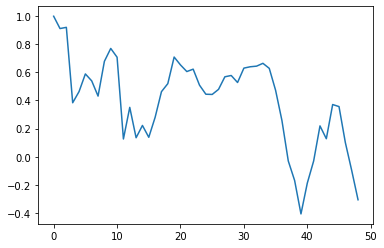

In [173]:
plt.plot(np.arange(49), correlation(np.load("facenet_with_aging/hash_sample_2.0/offset_0_aging.npy")[0], 
           np.load("facenet_with_aging/hash_sample_2.0/offset_25_aging.npy")[0], calc='col'))

In [84]:
data['name'] = stream_sample['name']
data['age'] = stream_sample['age']

In [85]:
data

filename  1000_StephenHawking_1_m.jpg  581_QueenElizabet_3_f.jpg  \
0                           11.403776                  12.316991   
1                           13.086160                  13.926107   
2                           12.926891                  14.171586   
3                            3.785507                   5.834437   
4                           12.810529                  13.168731   
...                               ...                        ...   
16483                       12.817739                  13.651924   
16484                       11.847052                  12.923585   
16485                        4.372844                   5.506862   
16486                        5.341465                   6.848069   
16487                       11.276891                  12.837040   

filename  756_WEBDuBois_4_m.jpg  507_AlKapone_5_m.jpg  \
0                     12.960657             10.563153   
1                     16.132158             13.361237   
2                     15.997928             13.533310   
3                     12.330589              3.967126   
4                     15.899908             12.467225   
...                         ...                   ...   
16483                 15.764987             13.045637   
16484                 15.893467             12.472619   
16485                 12.096045              3.205580   
16486                 12.600815              3.628457   
16487                 12.659178             11.959426   

filename  12780_MargaretOBrien_6_f.jpg  9667_MegRyan_7_f.jpg  \
0                            16.570822             10.834777   
1                            17.736132             14.805589   
2                            16.319780             14.174663   
3                            12.593128              7.458274   
4                            16.637522             12.344187   
...                                ...                   ...   
16483                        16.388790             13.957217   
16484                        17.182299             14.207540   
16485                        12.268156              6.980493   
16486                        12.146796              7.203274   
16487                        17.041504             13.268826   

filename  7401_MickeyRooney_8_m.jpg  10965_DonnaDouglas_9_f.jpg  \
0                         11.870045                   14.930239   
1                         14.572308                   16.870647   
2                         14.747889                   15.568808   
3                          7.128546                    9.745950   
4                         14.125450                   15.638652   
...                             ...                         ...   
16483                     14.540597                   15.878953   
16484                     13.760379                   16.008713   
16485                      6.661165                    9.374287   
16486                      7.031674                    9.304852   
16487                     13.176778                   15.107524   

filename  201_ElvisPresley_10_m.jpg  12783_MargaretOBrien_11_f.jpg  ...  \
0                          9.960647                      12.051121  ...   
1                         14.409312                      14.168417  ...   
2                         13.056075                      15.539419  ...   
3                          5.894501                       8.394800  ...   
4                         12.708462                      14.251645  ...   
...                             ...                            ...  ...   
16483                     14.021430                      14.135230  ...   
16484                     13.312588                      13.495418  ...   
16485                      5.475574                       7.502199  ...   
16486                      5.497628                       8.030571  ...   
16487                     11.728751                      13.827561  ...   

filename  11396_ZsaZsaG

In [90]:
import tensorflow as tf

embeddings_facenet = tf.concat(res2, axis=0)

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


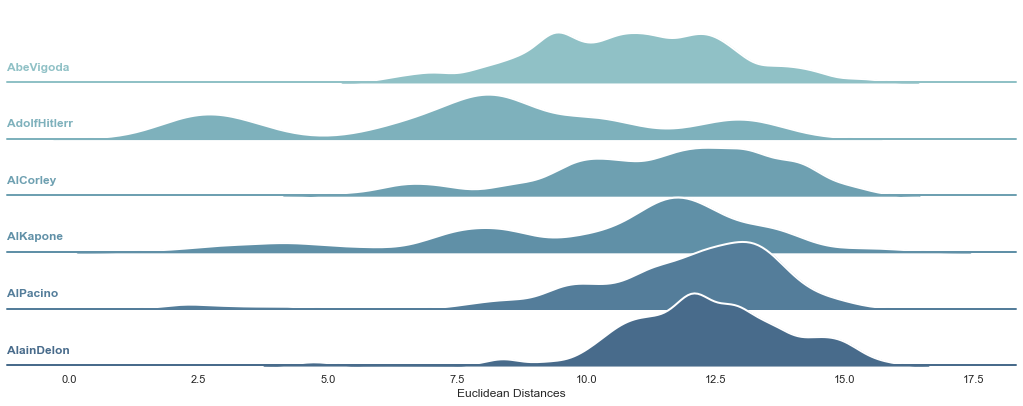

In [211]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
X = []
G = []
age_list = []
for ii, name in enumerate(np.unique(stream_sample['name'])[:6]):
    new_dataframe = stream_sample[stream_sample['name'] == name]
    age_group1 = new_dataframe.loc[(new_dataframe['age'] >= 1) & (new_dataframe['age'] <= 35)]
    age_group2 = new_dataframe.loc[(new_dataframe['age'] >= 36) & (new_dataframe['age'] <= 64)]
    age_group3 = new_dataframe.loc[(new_dataframe['age'] >= 65) & (new_dataframe['age'] <= 101)]
    
    x = np.array([])
    age_grp = []
    euclidean_distances_age_grp1 = np.array([])
    try:
        euclidean_distances_age_grp1 = euclidean_distances(embeddings_facenet.numpy()[age_group1.index.values])
    except Exception as e:
        pass
    euclidean_distances_age_grp2 = np.array([])
    try:
        euclidean_distances_age_grp2 = euclidean_distances(embeddings_facenet.numpy()[age_group2.index.values])
    except Exception as e:
        pass
    euclidean_distances_age_grp3 = np.array([])
    try:
        euclidean_distances_age_grp3 = euclidean_distances(embeddings_facenet.numpy()[age_group3.index.values])
    except Exception as e:
        pass
    
    try:
        x1 = np.tril(euclidean_distances_age_grp1)[np.tril(euclidean_distances_age_grp1)!=0]
        x = np.concatenate([x, x1], 0)
        age_grp += ['Group 1']*len(x1)
    except Exception as e:
        pass
    
    try:
        x2 = np.tril(euclidean_distances_age_grp2)[np.tril(euclidean_distances_age_grp2)!=0]
        x = np.concatenate([x, x2], 0)
        age_grp += ['Group 2']*len(x2)
    except Exception as e:
        pass
    
    try:
        x3 = np.tril(euclidean_distances_age_grp3)[np.tril(euclidean_distances_age_grp3)!=0]
        x = np.concatenate([x, x3], 0)
        age_grp += ['Group 3']*len(x3)
    except Exception as e:
        pass
    
    g = [name]*len(x)
    
    X.append(x.T.flatten())
    G.append(g)
    age_list.append(age_grp)
    
X = np.concatenate(X)
G = np.concatenate(G)
age = np.concatenate(age_list)

df = pd.DataFrame(dict(x=X, g=G, age=age))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal, size=1, legend_out=True)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, warn_singular=False)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5, warn_singular=False)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Euclidean Distances")
g.despine(bottom=True, left=True)

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


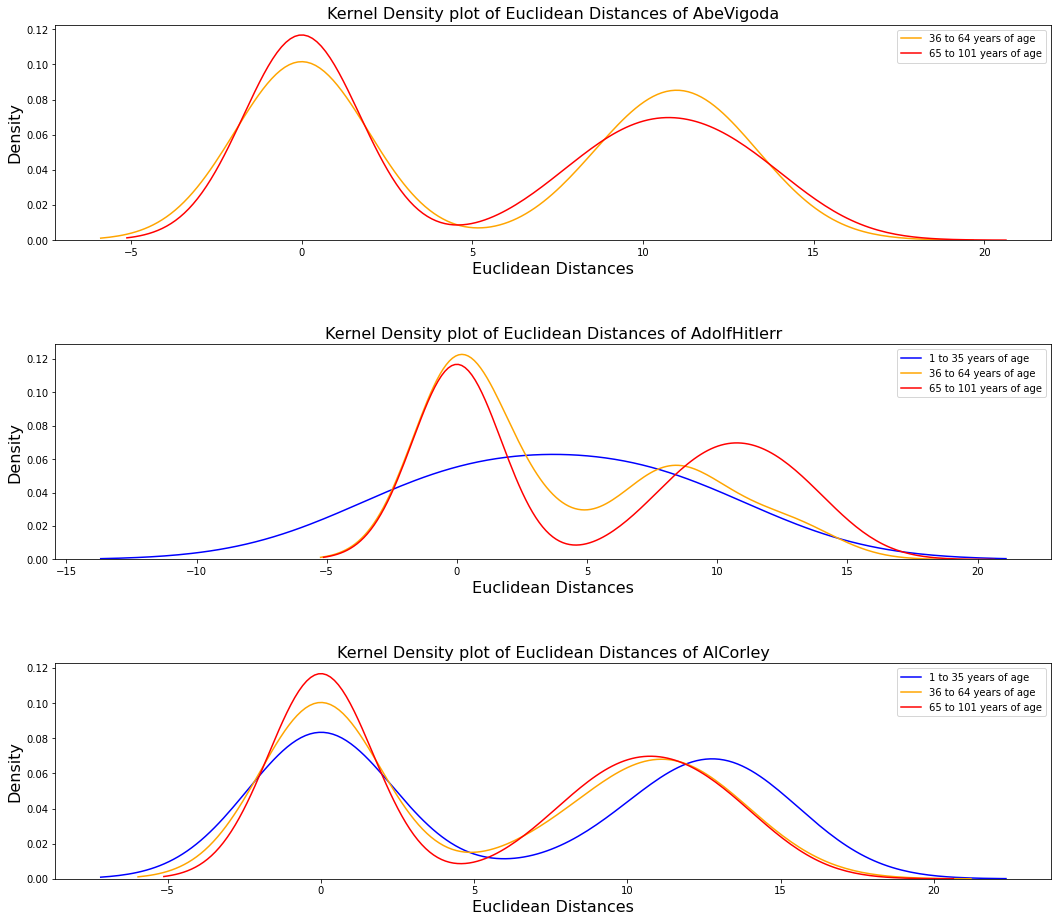

In [126]:
fig, ax = plt.subplots(3,1,figsize=(16,14))
import seaborn as sns
for ii, name in enumerate(np.unique(stream_sample['name'])[:3]):
    new_dataframe = stream_sample[stream_sample['name'] == name]
    age_group1 = new_dataframe.loc[(new_dataframe['age'] >= 1) & (new_dataframe['age'] <= 35)]
    age_group2 = new_dataframe.loc[(new_dataframe['age'] >= 36) & (new_dataframe['age'] <= 64)]
    age_group3 = new_dataframe.loc[(new_dataframe['age'] >= 65) & (new_dataframe['age'] <= 101)]
    
    try:
        euclidean_distances_age_grp1 = euclidean_distances(embeddings_facenet.numpy()[age_group1.index.values])
    except Exception as e:
        pass
    try:
        euclidean_distances_age_grp2 = euclidean_distances(embeddings_facenet.numpy()[age_group2.index.values])
    except Exception as e:
        pass
    try:
        euclidean_distances_age_grp3 = euclidean_distances(embeddings_facenet.numpy()[age_group3.index.values])
    except Exception as e:
        pass
    
    ax[ii].set_title("Kernel Density plot of Euclidean Distances of " + name, fontsize=16)
    ax[ii].set_xlabel("Euclidean Distances", fontsize=16)
    ax[ii].set_ylabel("Density", fontsize=16)
    fig.tight_layout(pad=5.0)
    try:
        sns.kdeplot(np.tril(euclidean_distances_age_grp1)[euclidean_distances_age_grp1!=0], color='blue', ax=ax[ii], label='1 to 35 years of age')
    except Exception as e:
        pass
    try:
        sns.kdeplot(np.tril(euclidean_distances_age_grp2)[euclidean_distances_age_grp2!=0], color='orange', ax=ax[ii], label='36 to 64 years of age')
    except Exception as e:
        pass
    try:
        sns.kdeplot(np.tril(euclidean_distances_age_grp3)[euclidean_distances_age_grp3!=0], color='red', ax=ax[ii], label='65 to 101 years of age')
    except Exception as e:
        pass
    ax[ii].legend()
    fig.show()

In [ ]:
corr = []
for ii, name in enumerate(np.unique(stream_sample['name'])[:6]):
    corr.append()

In [18]:
from sklearn.cluster import DBSCAN, OPTICS, AffinityPropagation, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler

bandwidth = estimate_bandwidth(power_new, quantile=0.05, n_samples=100)
mshift = MeanShift(bandwidth=bandwidth)
# X_power = MinMaxScaler(feature_range=(0,1)).fit_transform(power_new)
mshift.fit(power_new)

MeanShift(bandwidth=8.025466865935721)

In [13]:
drift = False
y_true = []
y_value = []
for col in range(power_new.shape[1]):
    value = power_new[:, col]
    if value.sum() > 50:
        drift = 1
    else:
        drift = 0
    y_true.append(drift)
    y_value.append(value.mean())

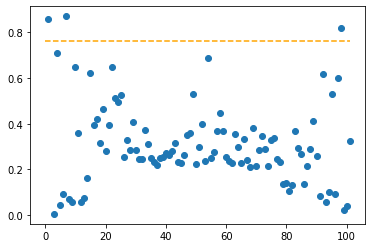

In [17]:
plt.scatter(cols, y_value)
plt.hlines(y=0.76, xmax=101, xmin=0, linestyle='dashed', color='orange')
plt.show()

In [18]:
y_value = np.array(y_value)
print("No. of Samples: ", y_value.shape[0])
positive_samples = y_value[(y_value <= 0.76)]
drifted_samples = y_value[(y_value > 0.76)]
print("No. of Drifted Samples: ", drifted_samples.shape[0])
print("No. of Positive Samples: ", positive_samples.shape[0])
print("Drifted Samples: ", drifted_samples)
print("Drifted Ages: ", np.array(cols)[(y_value > 0.76)])

No. of Samples:  100
No. of Drifted Samples:  3
No. of Positive Samples:  97
Drifted Samples:  [0.85680598 0.86918369 0.81855644]
Drifted Ages:  [ 1  7 98]


In [26]:
mshift.labels_

array([ 1,  1,  1,  1, 14, 20,  1, 19, 17, 15,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0, 11,
       11,  0,  0,  0,  0,  2,  2,  2,  0,  0,  0,  2,  2,  7, 12,  2,  2,
        9, 13,  2,  2,  2,  2,  2,  4,  4, 10,  2,  2,  4,  2,  4,  4,  2,
        4,  4,  8,  2,  3,  4,  2,  5,  5,  3,  3,  3,  3,  3,  5,  0,  3,
        1,  3,  1,  1,  3,  1,  1,  1,  6, 18,  1, 16,  1,  1,  1],
      dtype=int64)

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(power_new[:,:])
pca.explained_variance_ratio_

array([0.15591225, 0.10072582])

In [21]:
from tqdm import tqdm

stream_sample = metadata_agedb.copy()

print("Extracting the Dataset:")
res2 = []
images2 = []
for ij, str_samp in tqdm(enumerate(stream_sample.iterrows())):
    _, str_samp = str_samp
    filename2 = str_samp['filename']
    img2 = '../metadata/AgeDB' + "\\" + filename2
    image2 = skimage.transform.resize(skimage.io.imread(img2), (160,160))
    if len(image2.shape) == 2:
        image2 = np.moveaxis(np.moveaxis(np.vstack([np.expand_dims(image2, 0)]*3), 0, 2), 0, 1)
    images2.append(image2)
    if (ij+1) % 640 == 0:
        res2.append(facenet_model(l2_normalize(prewhiten(np.vstack([img for img in images2]).reshape(-1,160,160,3)))))
        images2 = []

res2.append(facenet_model(l2_normalize(prewhiten(np.vstack([img for img in images2]).reshape(-1,160,160,3)))))

Extracting the Dataset:


16488it [17:24, 15.78it/s]


In [22]:
pickle.dump(res2, open("agedb_inferences_facenet.pkl", "wb"))